# Summary of Modeling for SPDR ETFs

In this notebook, I will summarize my findings from iterating through a host of models for the 11 sector ETFs for time frames of 1, 3, 6, and 12 months. The best scoring models performed incredibly well, and did not exhibit any characteristics of overfitting. That being said, on certain instances where the model predicted a given ETF would appreciate over its target time period and that ETF lost money, the losses had the potential to be quite large. I will begin by summarizing each sector's performance separately. 

### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions 

![One Tree of an ExtraTreesClassifier Ensemble](./Files/Energy_Grid_12m_tree.jpg)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

import datetime as dt

# New import of my custom class
from classification_classes import Model
from spider_classes import Materials, Energy, Financials, Industrials, Technology, Staples, Utilities, Health, \
Consumer, Real_Estate, Communication_Services
from other_functions import compare_curves

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)
sns.set_style("dark")

import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

import pickle

In [4]:
# Feature Importances for the best models of each sector/timeframe
feature_importances = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Feature_Importances.csv')
feature_importances.rename(columns={"Unnamed: 0": "Model Target"}, inplace=True)
feature_importances.set_index("Model Target", inplace=True)

# Complete table of results
models_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/ALL_MODEL_DATA.csv', index_col=0)
models_df.loc[28, 'name'] = "Gridsearched ETC Materials 12-Month"

# Original Data 
df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/FULL_DATA_W_PERC_CHANGES.csv')
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

In [5]:
# Load Pickled Classes -> if you want access, please reach out to me directly

with open('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_classes.pkl', 'rb') as file:
    model_collection = pickle.load(file)

In [6]:
# Providing access to Class Objects

Materials = model_collection[0]
Energy = model_collection[1]
Financials = model_collection[2]
Industrials = model_collection[3]
Technology = model_collection[4]
Staples = model_collection[5]
Utilities = model_collection[6]
Health = model_collection[7]
Consumer_Disc = model_collection[8]
Real_Estate = model_collection[9]
Comms = model_collection[10]

In [7]:
# Metric dfs of the models from the previous notebook

Materials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Materials.csv', index_col=0)
Energy_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Energy.csv', index_col=0)
Financials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Financials.csv', index_col=0)
Industrials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Industrials.csv', index_col=0)
Technology_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Technology.csv', index_col=0)
Staples_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Staples.csv', index_col=0)
Utilities_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Utilities.csv', index_col=0)
Health_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Health_Care.csv', index_col=0)
Consumer_Disc_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Consumer_Disc.csv', index_col=0)
Real_Estate_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Real_Estate.csv', index_col=0)
Comms_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Communication_Services.csv', index_col=0)
Materials_df.loc[28, 'name'] = "Gridsearched ETC Materials 12-Month"
Materials[32].name = "Gridsearched ETC Materials 12-Month"

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_test_accuracy(df, sector_name:str, num_include=-1):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(10,7))
    palette = sns.color_palette("flare", n_colors=10)
    data = df[['name', 'test_accuracy']].sort_values(by="test_accuracy", ascending=False)[0:num_include]
    sns.barplot(data=data, y='name', x="test_accuracy", palette=palette)
    ax.set_xlabel("Test Accuracy")
    ax.set_ylabel("Model Name")
    ax.set_title(f"Performance of Models - {sector_name}")
    ax.set_xticks(np.arange(0,1,.1))
    ax.set_xticklabels(np.arange(0,100,10))
    plt.grid(False);
    
    
    
feature_importances = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Feature_Importances.csv')
feature_importances.rename(columns={"Unnamed: 0": "Model Target"}, inplace=True)
feature_importances.set_index("Model Target", inplace=True)
    
    
    
def print_feature_importances(start, stop, interval=1, feats=5, data=feature_importances):
    for i in range(start, stop, interval):
        print("*" *40)
        print(f"Top {feats} Feature Importance(s):")
        print(feature_importances.iloc[i].sort_values(ascending=False)[:feats])
        
        

def describe_predictions(model, ticker, df=df, cat=1, box=False):
    targets = df[df["Ticker"] == ticker][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                                         'Twelve_Month_Change']]

    combined_df = model.X_test.join(targets)
    predictions = list(model.y_pred)
    combined_df["Y_PREDS"] = predictions
    
    # Add this stuff
    if box:
        assess_positive_preds = combined_df[combined_df["Y_PREDS"] == 1]

        fig, ax = plt.subplots(figsize=(6,5.5))
        sns.set_style("darkgrid")
        palette = sns.color_palette("rocket_r", n_colors=6)
        sns.boxplot(assess_positive_preds[["One_Month_Change", 'Three_Month_Change','Six_Month_Change',\
                                           'Twelve_Month_Change']], ax=ax, palette=palette)
        ax.set_title(f"{model.name} Box Plot for Each Timeframe")
        plt.xticks(rotation=30)
        ax.set_ylabel("Percentage Change in Decimals");
    else:
        print("Set 'box' to 'True' if you want to see box plots")

    return combined_df[combined_df["Y_PREDS"] == cat][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
                                                     'Twelve_Month_Change']].describe()


def show_time_horizon(df, time_horizon):
    time_dict = {"One":"1-Month", "Three":"3-Month", "Six":'6-Month', "Twelve":'12-Month'}
    return df[df['name'].str.contains(str(time_dict[time_horizon]))].sort_values(by="test_accuracy", ascending=False)

# Top Ten Models Overall

In [9]:
models_df.sort_values(by="test_accuracy", ascending=False)[:10]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
28,Gridsearched ETC Materials 12-Month,0.979024,0.986948,0.983155,0.985039,0.060795,0.985274,0.990602,0.988743,0.989671,0.092646,0.996232
266,Communication_Services Extra Trees 12-Month,0.982578,0.983815,0.990826,0.987154,0.092066,0.985075,0.982955,0.994253,0.988571,0.049172,0.998961
265,Communication_Services Random Forest 12-Month,0.977609,0.976476,0.990826,0.983553,0.063403,0.985075,0.977528,1.000000,0.988636,0.060206,0.997402
262,"GridSearched Best-Model, 6-Month Communication...",0.978882,0.981666,0.983505,0.982520,0.130085,0.985075,1.000000,0.975758,0.987730,0.055740,0.997823
260,Communication_Services Extra Trees 6-Month,0.976390,0.977591,0.983505,0.980512,0.118715,0.985075,1.000000,0.975758,0.987730,0.047281,0.998970
259,Communication_Services Random Forest 6-Month,0.977640,0.979646,0.983505,0.981505,0.094233,0.985075,1.000000,0.975758,0.987730,0.062765,0.997499
76,"GridSearched Best-Model, 12-Month Financials",0.979469,0.983879,0.983866,0.983857,0.065058,0.981928,0.987368,0.984260,0.985812,0.053268,0.998809
26,Materials Extra Trees 12-Month,0.979024,0.987252,0.982836,0.985032,0.069167,0.981928,0.987793,0.986867,0.987330,0.095225,0.996001
244,"GridSearched Best-Model, 12-Month Real_Estate",0.957293,0.970728,0.961212,0.965901,0.145373,0.981735,0.989091,0.981949,0.985507,0.076145,0.997679
268,"GridSearched Best-Model, 12-Month Communicatio...",0.982578,0.981930,0.992661,0.987189,0.064478,0.981343,0.977401,0.994253,0.985755,0.067219,0.995751


<hr style="border: 4px solid black">

# Best Models for Different Time Horizons
### Top 5 Models for 1-Month Predictions

In [30]:
show_time_horizon(models_df, "One").sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
226,"GridSearched Best-Model, 1-Month Real_Estate",0.908542,0.911152,0.940578,0.925358,0.253725,0.931507,0.938182,0.952030,0.945055,0.223912,0.975937
224,Real_Estate Extra Trees 1-Month,0.907785,0.910072,0.940586,0.924791,0.273221,0.922374,0.934066,0.940959,0.937500,0.221615,0.975098
8,"GridSearched ETC, 1-Month XLB",0.896675,0.906934,0.923333,0.915036,0.300330,0.921017,0.932522,0.936667,0.934590,0.221965,0.976621
154,"GridSearched Best-Model, 1-Month Utilities",0.907387,0.917988,0.934746,0.926280,0.276410,0.919679,0.932240,0.936334,0.934283,0.227465,0.970891
104,Technology Extra Trees 1-Month,0.914084,0.923342,0.937140,0.930150,0.269937,0.919009,0.929825,0.937017,0.933407,0.222208,0.973039


### Top 5 Models for 3-Month Predictions

In [31]:
show_time_horizon(models_df, "Three").sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
112,"GridSearched Best-Model, 3-Month Technology",0.954922,0.958811,0.974170,0.966398,0.140868,0.979920,0.984095,0.986056,0.985075,0.141874,0.993308
110,Technology Extra Trees 3-Month,0.954029,0.956628,0.975177,0.965784,0.159013,0.976573,0.984016,0.981076,0.982544,0.138792,0.993223
109,Technology Random Forest 3-Month,0.947559,0.950278,0.972158,0.961046,0.180495,0.963855,0.969368,0.977092,0.973214,0.138972,0.990442
230,Real_Estate Extra Trees 3-Month,0.930648,0.940567,0.958427,0.949330,0.157819,0.963470,0.972881,0.972881,0.972881,0.200511,0.988005
206,Consumer Extra Trees 3-Month,0.945324,0.958315,0.957964,0.958132,0.145978,0.960509,0.967709,0.972617,0.970157,0.190052,0.987507


### Top 5 Models for 6-Month Predictions

In [32]:
show_time_horizon(models_df, "Six").sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
262,"GridSearched Best-Model, 6-Month Communication...",0.978882,0.981666,0.983505,0.982520,0.130085,0.985075,1.000000,0.975758,0.987730,0.055740,0.997823
260,Communication_Services Extra Trees 6-Month,0.976390,0.977591,0.983505,0.980512,0.118715,0.985075,1.000000,0.975758,0.987730,0.047281,0.998970
259,Communication_Services Random Forest 6-Month,0.977640,0.979646,0.983505,0.981505,0.094233,0.985075,1.000000,0.975758,0.987730,0.062765,0.997499
261,Communication_Services XGBoost 6-Month,0.973890,0.975405,0.981443,0.978409,0.104222,0.981343,0.993827,0.975758,0.984709,0.054013,0.997705
235,Real_Estate Random Forest 6-Month,0.967225,0.980101,0.969591,0.974722,0.105576,0.979452,0.992481,0.974170,0.983240,0.083799,0.995658


### Top 5 Models for 12-Month Predictions

In [33]:
show_time_horizon(models_df, "Twelve").sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
28,Gridsearched ETC Materials 12-Month,0.979024,0.986948,0.983155,0.985039,0.060795,0.985274,0.990602,0.988743,0.989671,0.092646,0.996232
266,Communication_Services Extra Trees 12-Month,0.982578,0.983815,0.990826,0.987154,0.092066,0.985075,0.982955,0.994253,0.988571,0.049172,0.998961
265,Communication_Services Random Forest 12-Month,0.977609,0.976476,0.990826,0.983553,0.063403,0.985075,0.977528,1.000000,0.988636,0.060206,0.997402
76,"GridSearched Best-Model, 12-Month Financials",0.979469,0.983879,0.983866,0.983857,0.065058,0.981928,0.987368,0.984260,0.985812,0.053268,0.998809
26,Materials Extra Trees 12-Month,0.979024,0.987252,0.982836,0.985032,0.069167,0.981928,0.987793,0.986867,0.987330,0.095225,0.996001


# Sector Analysis

<hr style="border: 4px solid black">

# Notebook Analysis Layout:
- Materials
- Energy
- Financials
- Industrials 
- Technology
- Staples 
- Utilities 
- Health Care
- Consumer Discretionary 
- Real Estate 
- Communication Services
- ##### Final Summary

# Materials XLB

The data for the Materials sector shows that on a shorter time horizon, momentum has the greatest relative importance, as evidenced by the technical indicators having the greatest influence on increasing purity. The longer the time horizon, the more macro factors like interest rates and GDP were able to create meaningful splits in our tree based models. Considering the best model was predicting 12-Month appreciation, the "describe" table and confusion matrix are very instuctive in evaluating performance. Of note, even this extremely accurate predictive model still had 10 false positives, and the worst false positive resulted in a 5.7% loss. The best prediction resulted in a 92.5% gain. 

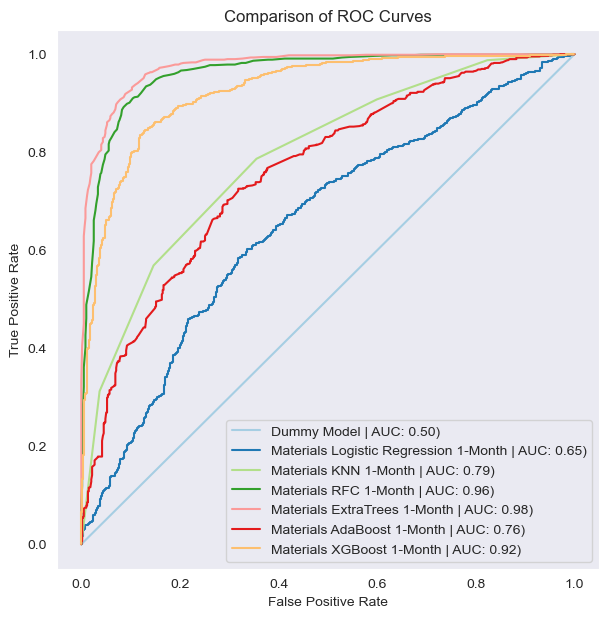

In [10]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Materials[0], Materials[1],Materials[2],Materials[3],Materials[4],Materials[5], Materials[6]])

### Best Models for the Sector

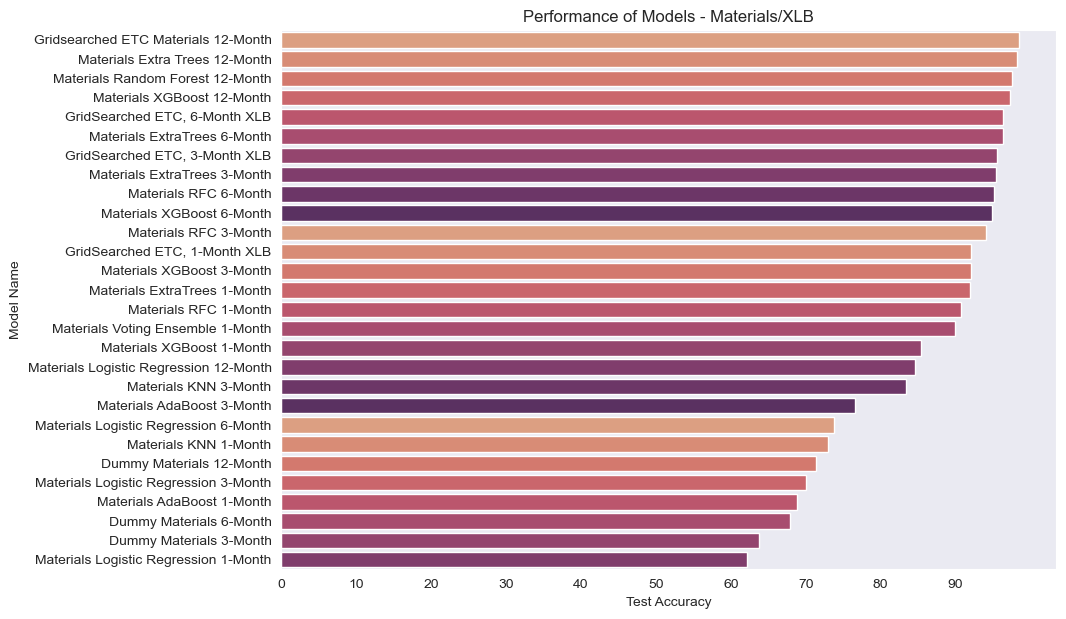

In [213]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Materials_df, "Materials/XLB", num_include=-1)

In [12]:
# Top 5 Materials Models
Materials_df.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
28,Gridsearched ETC Materials 12-Month,0.979024,0.986948,0.983155,0.985039,0.060795,0.985274,0.990602,0.988743,0.989671,0.092646,0.996232
27,Materials Extra Trees 12-Month,0.979024,0.987252,0.982836,0.985032,0.069167,0.981928,0.987793,0.986867,0.987330,0.095225,0.996001
26,Materials Random Forest 12-Month,0.971659,0.979679,0.979976,0.979821,0.087653,0.975904,0.984934,0.981238,0.983083,0.117441,0.994878
25,Materials XGBoost 12-Month,0.969429,0.978383,0.978071,0.978221,0.092013,0.973226,0.981238,0.981238,0.981238,0.083920,0.994275
22,"GridSearched ETC, 6-Month XLB",0.956705,0.963759,0.973099,0.968345,0.128323,0.963855,0.966019,0.981262,0.973581,0.151845,0.990050


### How did our model perform when predicting "BUY"?
Our best model was a 12-month model, based on the ExtraTreesClassifier. As you can see below, the `median return on predicted "buys" was 16%.` The worst outcome of 12-Month positive predictions was a `loss of 5.7%`

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1064.000000,1064.000000,1064.000000,1064.000000
mean,0.015206,0.047595,0.095232,0.184612
std,0.063396,0.092033,0.117998,0.131313
min,-0.328934,-0.367629,-0.249243,-0.057450
25%,-0.017188,-0.002969,0.021982,0.099510
50%,0.018326,0.050263,0.090358,0.159914
75%,0.048695,0.099596,0.161215,0.240284
max,0.319829,0.513839,0.650620,0.925471


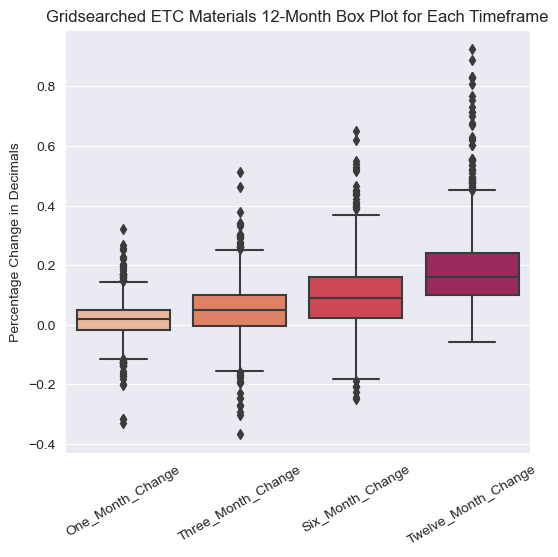

In [220]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Materials[32], "XLB", cat=1, box=True)

### Improvements
The confusion matrices below show how substantially our best model improved over the dummy model. The tree diagram at the beginning of the notebook displays how intricate decision trees can be, but impressively, none of the models were overfit in a meaningful way.

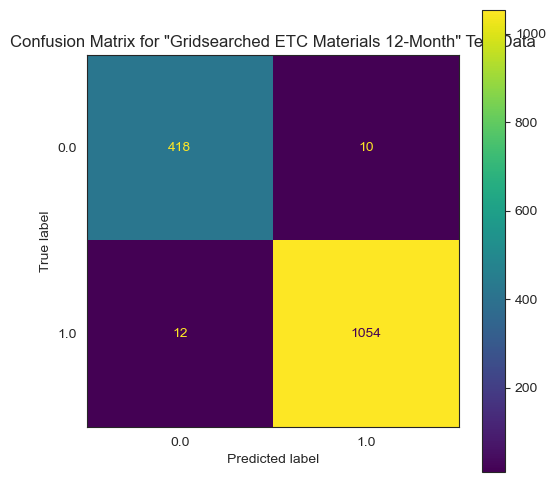

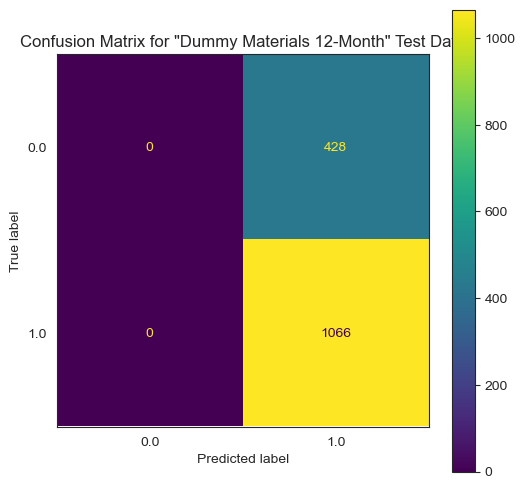

In [221]:
# Shows the best model's predictions and the dummy for that particular time horizon

Materials[32].confusion_matrix(), Materials[23].confusion_matrix();

### Feature Importances
Feature Importances for each time-horizon's best model. Keep in mind that after preprocessing and One Hot Encoding, that these models were built with `31 total feature columns.`  If all features were of equivalent value, they would each have an importance of roughly `0.032`. Also, these importances are not coefficients, but rather relative values of all features' importance, summing to 1.

In [18]:
# Feature Importances for each time-horizon's best model
print_feature_importances(0, 4, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
20_day_SMA               0.054590
MACD                     0.053367
lower_bollinger_band     0.053166
lowest_bollinger_band    0.052988
ATR                      0.052783
Name: 1 Month XLB, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates           0.061072
lowest_bollinger_band    0.051249
one_up_bollinger_band    0.049634
lower_bollinger_band     0.049101
20_day_SMA               0.047810
Name: 3-Month XLB, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates           0.069081
GDP                      0.063467
20_day_SMA               0.049903
upper_bollinger_band     0.049809
one_up_bollinger_band    0.048229
Name: 6-Month XLB, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                      0.075225
cycle_year_1             0.072214
Interest Rates           0.069435
upper_

<hr style="border: 4px solid black">

# Energy XLE

Once again, the further out into the future our predictions, the more accurate our models became. My top 8 models were all for 6 or 12 month predictions. The short term predictions were once again more influenced by technical indicators, and the longer term predictions moreso by GDP and interest rates. Interestingly, `presidential term year 1` has shown to be a somewhat important feature. Another interesting note is that Logistic Regression actually produced a model that was less accurate on test data than our dummy model was, even though its AUC and other metrics were slightly better. A constant theme of this analysis was the underperformance of Logistic Regression.  

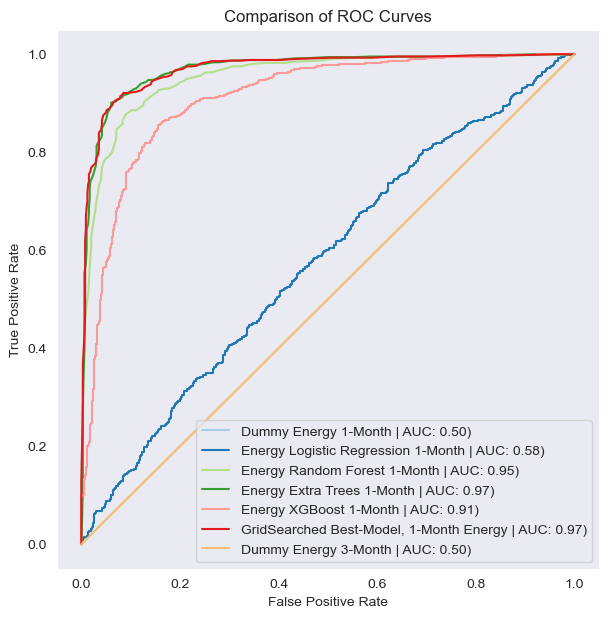

In [11]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Energy[0], Energy[1], Energy[2],Energy[3],Energy[4],Energy[5], Energy[6]])

### Best Models for the Sector

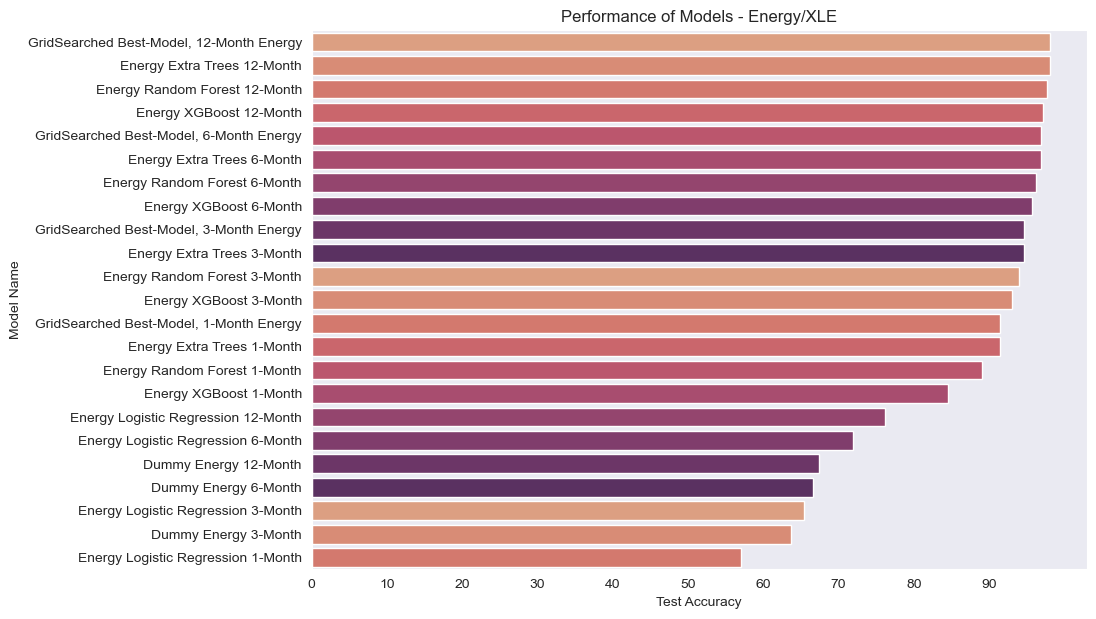

In [223]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Energy_df, "Energy/XLE", num_include=-1)

In [16]:
# These were the models with the highest accuracy score for this ETF

Energy_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Energy",0.980361,0.983175,0.987150,0.985152,0.063432,0.980589,0.982249,0.989076,0.985651,0.056005,0.998331
21,Energy Extra Trees 12-Month,0.979468,0.982168,0.986812,0.984482,0.068770,0.980589,0.981299,0.990070,0.985665,0.055483,0.998220
20,Energy Random Forest 12-Month,0.974559,0.977501,0.984106,0.980788,0.076852,0.976573,0.978346,0.987090,0.982699,0.071217,0.997273
22,Energy XGBoost 12-Month,0.970987,0.974820,0.981399,0.978094,0.087563,0.971888,0.973503,0.985104,0.979269,0.083846,0.996035
17,"GridSearched Best-Model, 6-Month Energy",0.964739,0.975521,0.969359,0.972410,0.133980,0.968541,0.974950,0.977889,0.976417,0.093572,0.995605


### How did our model perform when predicting "BUY"?
The best model was a 12-month model, based on the ExtraTreesClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 21.9%. The worst outcome on a predicted "buy" was a loss of 3.93%.` 

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1014.000000,1014.000000,1014.000000,1014.000000
mean,0.022356,0.068303,0.129365,0.259073
std,0.071422,0.107046,0.135993,0.185235
min,-0.353647,-0.241060,-0.225253,-0.039360
25%,-0.020025,0.002462,0.042883,0.125241
50%,0.023064,0.056387,0.109650,0.219052
75%,0.064840,0.125398,0.200028,0.358770
max,0.327986,0.579674,0.774847,1.113624


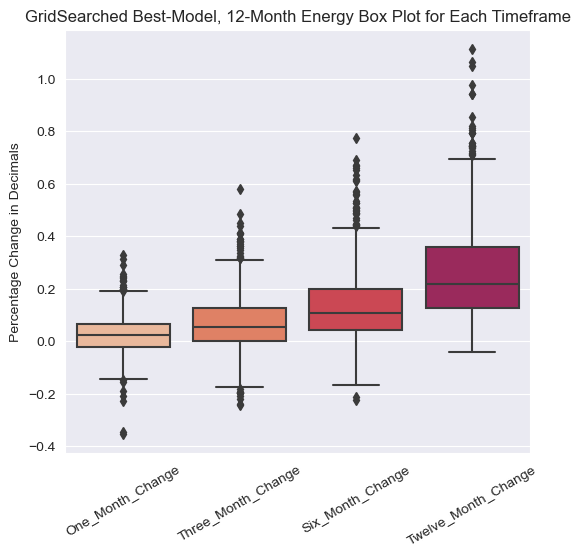

In [224]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Energy[23], "XLE", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

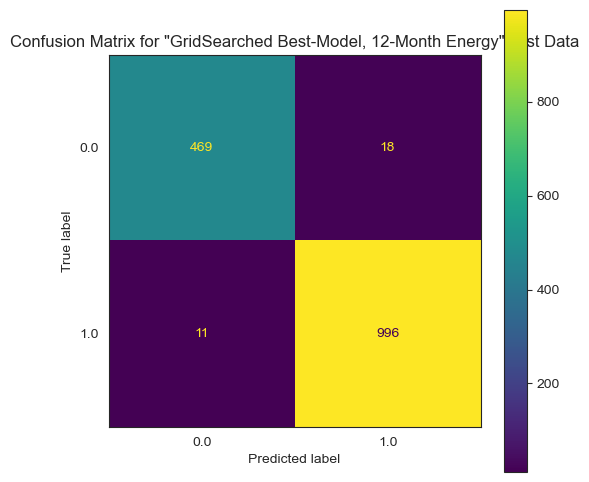

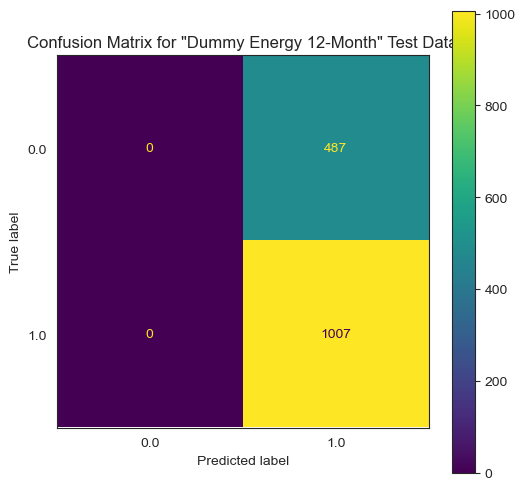

In [44]:
# Shows the best model's predictions and the dummy for that particular time horizon
Energy[23].confusion_matrix(), Energy[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [22]:
# Feature Importances for each time-horizon's best model
print_feature_importances(4, 8, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
upper_bollinger_band     0.053686
one_up_bollinger_band    0.051793
20_day_SMA               0.051593
Interest Rates           0.050910
ATR                      0.050849
Name: 1_Month XLE, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                      0.052437
Interest Rates           0.051079
ATR                      0.051011
Close                    0.048154
one_up_bollinger_band    0.047854
Name: 3_Month XLE, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates           0.063015
GDP                      0.057262
cycle_year_1             0.052507
one_up_bollinger_band    0.047935
High                     0.046299
Name: 6_Month XLE, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                      0.075225
cycle_year_1             0.072214
Interest Rates           0.069435
upper_

<hr style="border: 4px solid black">

# Financials XLF

Once again, the further out into the future our predictions, the more accurate our models became. My top 8 models were all for 6 or 12 month predictions. The short term predictions were once again more influenced by technical indicators, and the longer term predictions moreso by GDP and interest rates. Interestingly, `presidential term year 3` made an appearance as an important feature, as did `ATR, a technical indicator intended to measure volatility.` `Logistic Regression AGAIN produced a model that was less accurate on test data` than our dummy model was.

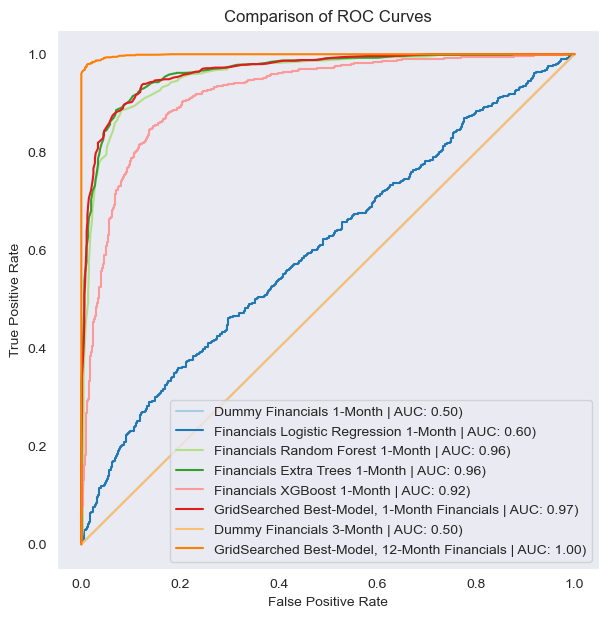

In [225]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Financials[0], Financials[1], Financials[2],Financials[3],Financials[4],Financials[5], \
                Financials[6], Financials[23]])

# Financials[23] is the best model overall for this sector

### Best Models for the Sector

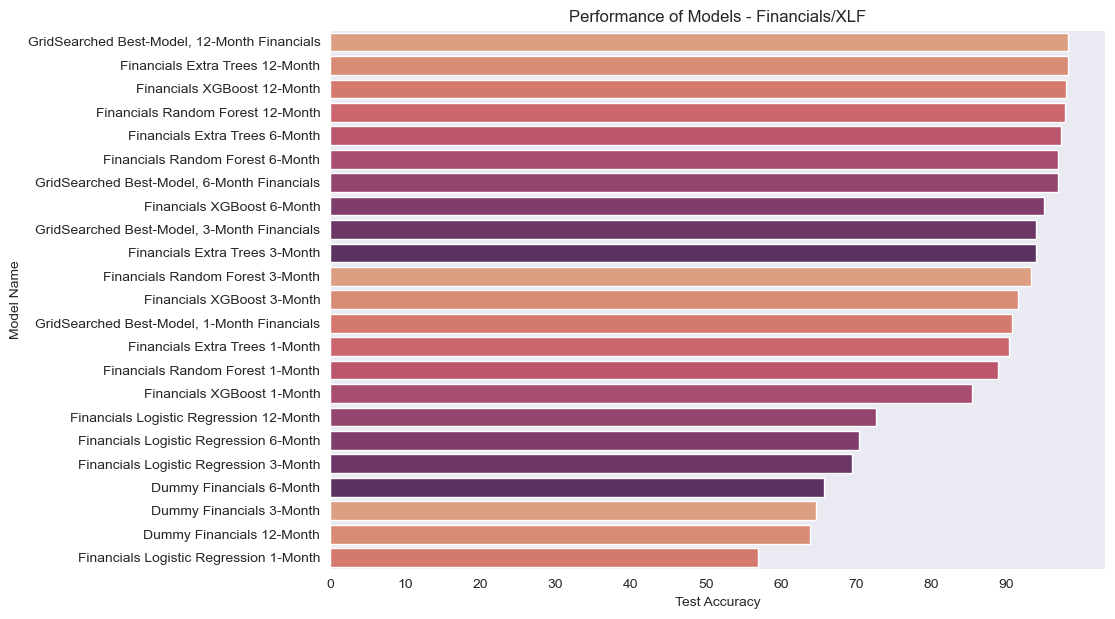

In [226]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Financials_df, "Financials/XLF", num_include=-1)

In [46]:
# These were the models with the highest accuracy score for this ETF

Financials_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Financials",0.979469,0.983879,0.983866,0.983857,0.065058,0.981928,0.987368,0.984260,0.985812,0.053268,0.998809
21,Financials Extra Trees 12-Month,0.979023,0.981827,0.985269,0.983537,0.066500,0.981258,0.987355,0.983211,0.985279,0.055513,0.998686
22,Financials XGBoost 12-Month,0.967866,0.974769,0.974749,0.974721,0.095076,0.979250,0.985263,0.982162,0.983710,0.066435,0.997269
20,Financials Random Forest 12-Month,0.972776,0.978630,0.978609,0.978597,0.094470,0.977912,0.986258,0.979014,0.982622,0.081450,0.997924
15,Financials Extra Trees 6-Month,0.963849,0.970263,0.972963,0.971603,0.140160,0.971888,0.980573,0.976578,0.978571,0.089501,0.995073


### How did our model perform when predicting "BUY"?
The best model was a 12-month model, again, based on the ExtraTreesClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 17%. The worst outcome on a predicted "buy" was a loss of 1.95%.` 

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,950.000000,950.000000,950.000000,950.000000
mean,0.013592,0.048445,0.105341,0.203030
std,0.075443,0.106085,0.127367,0.159059
min,-0.391374,-0.433875,-0.284383,-0.019450
25%,-0.016996,0.001818,0.033155,0.097900
50%,0.016515,0.046507,0.093335,0.169777
75%,0.045444,0.097120,0.166316,0.269558
max,0.556485,0.736442,1.064366,1.199291


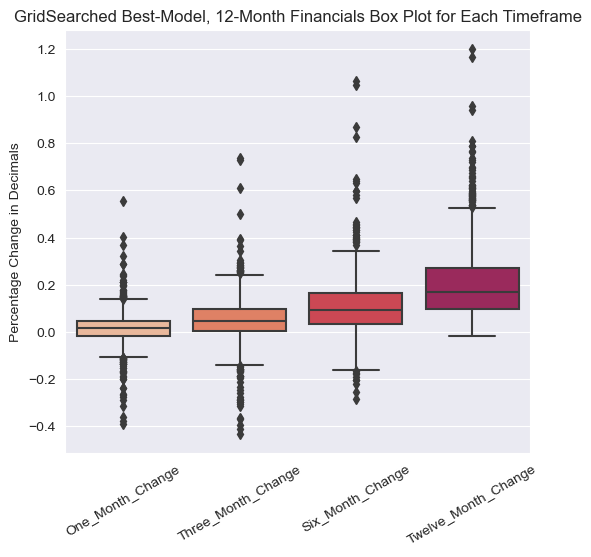

In [227]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Financials[23], "XLF", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

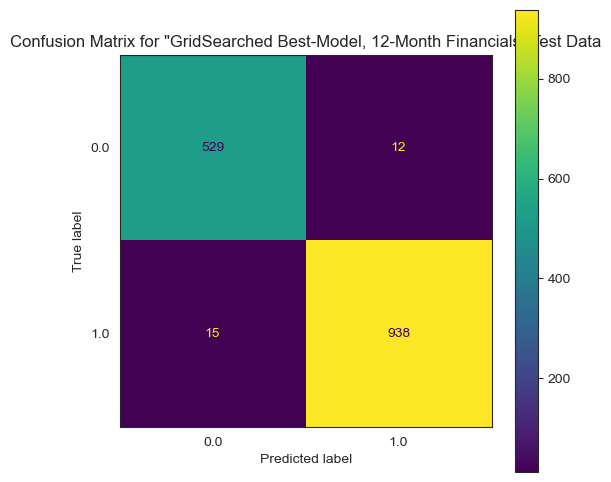

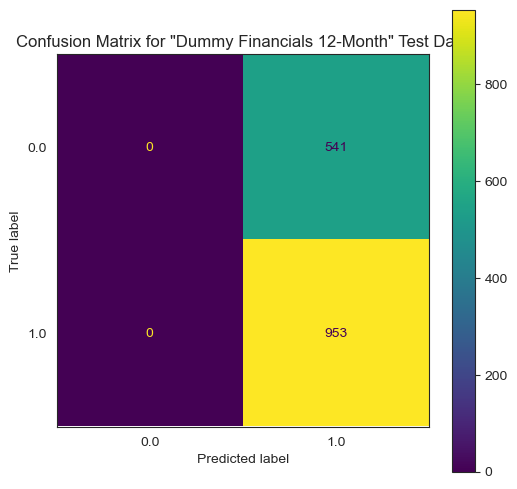

In [228]:
# Shows the best model's predictions and the dummy for that particular time horizon
Financials[23].confusion_matrix(), Financials[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [55]:
# Feature Importances for each time-horizon's best model
print_feature_importances(8, 12, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
MACD                     0.054893
one_up_bollinger_band    0.052939
Interest Rates           0.051268
20_day_SMA               0.051196
lower_bollinger_band     0.051067
Name: 1_Month XLF, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates           0.061739
GDP                      0.056825
ATR                      0.050515
20_day_SMA               0.047480
one_up_bollinger_band    0.047472
Name: 3_Month XLF, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                     0.083481
Interest Rates          0.071400
garman_klass_vol        0.050443
upper_bollinger_band    0.048443
cycle_year_3            0.047609
Name: 6_Month XLF, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP               0.085980
cycle_year_3      0.054509
Interest Rates    0.053144
High              0.050724
ATR  

<hr style="border: 4px solid black">

# Industrials XLI

Once again, the further out into the future our predictions, the more accurate our models became. The short term- technical indicators, longer term macro-economic trends continued. Interestingly, `presidential term year 1` has shown to be a somewhat important feature. Another interesting note is that Logistic Regression actually produced a model that was less accurate on test data than our dummy model was, even though its AUC and other metrics were slightly better. A constant theme of this analysis was the underperformance of Logistic Regression. It is important to note that `median and minimum performance outcomes were comparable to Materials`, but worse than Financials and Energy.

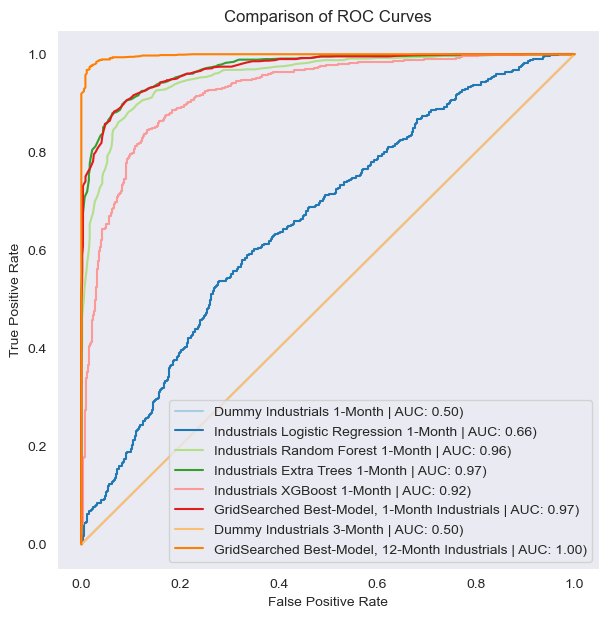

In [67]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Industrials[0], Industrials[1], Industrials[2],Industrials[3],Industrials[4],Industrials[5], \
                Industrials[6], Industrials[23]])

# 23 was the best model of this sector

### Best Models for the Sector

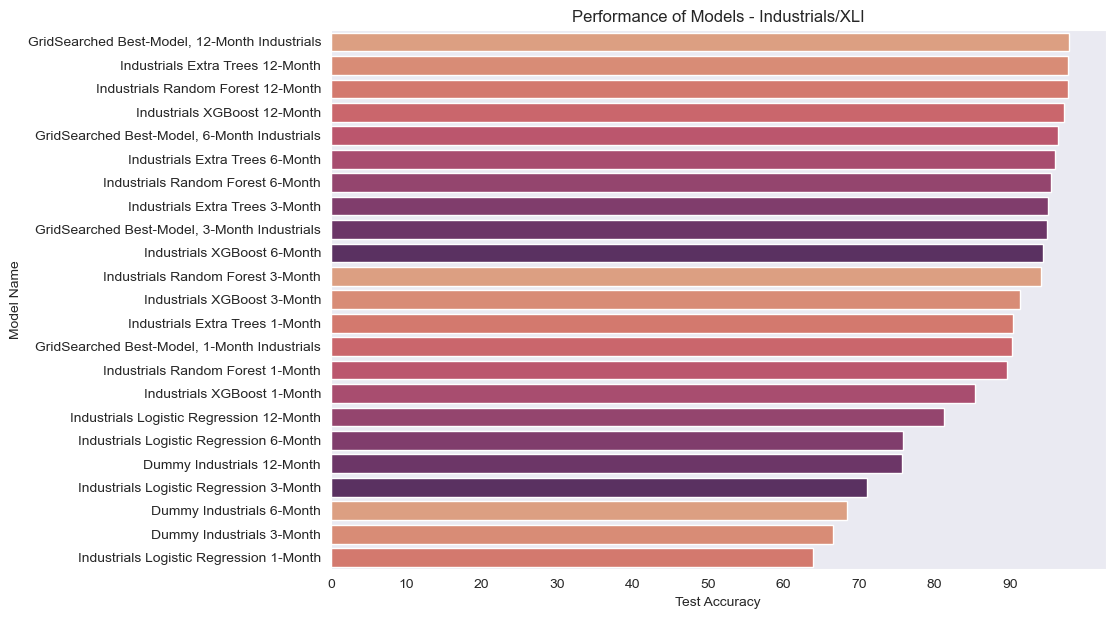

In [229]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Industrials_df, "Industrials/XLI", num_include=-1)

In [57]:
# These were the models with the highest accuracy score for this ETF

Industrials_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Industrials",0.971658,0.976591,0.985586,0.981040,0.103026,0.977912,0.981579,0.989390,0.985469,0.058677,0.997920
21,Industrials Extra Trees 12-Month,0.970319,0.976270,0.984084,0.980131,0.104381,0.977242,0.979878,0.990274,0.985048,0.061131,0.997636
20,Industrials Random Forest 12-Month,0.965857,0.972105,0.982282,0.977155,0.132400,0.977242,0.980719,0.989390,0.985035,0.080270,0.996709
22,Industrials XGBoost 12-Month,0.961840,0.967469,0.981682,0.974513,0.118401,0.971218,0.975524,0.986737,0.981099,0.099156,0.993765
17,"GridSearched Best-Model, 6-Month Industrials",0.966524,0.973307,0.977167,0.975220,0.125311,0.963186,0.974460,0.971596,0.973026,0.103829,0.992892


### How did our model perform when predicting "BUY"?
The best model was a 12-month model, based on the ExtraTreesClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 15.9%. The worst outcome on a predicted "buy" was a loss of 4.6%.`
### Worse performance of median and min outcomes compared to Energy and Financials

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1140.000000,1140.000000,1140.000000,1140.000000
mean,0.013728,0.044334,0.087329,0.175453
std,0.056990,0.084240,0.110127,0.130865
min,-0.388168,-0.401429,-0.260406,-0.046286
25%,-0.013228,0.000460,0.018929,0.083478
50%,0.016654,0.047557,0.089781,0.158974
75%,0.043902,0.094412,0.151884,0.243934
max,0.264921,0.471180,0.610720,0.900561


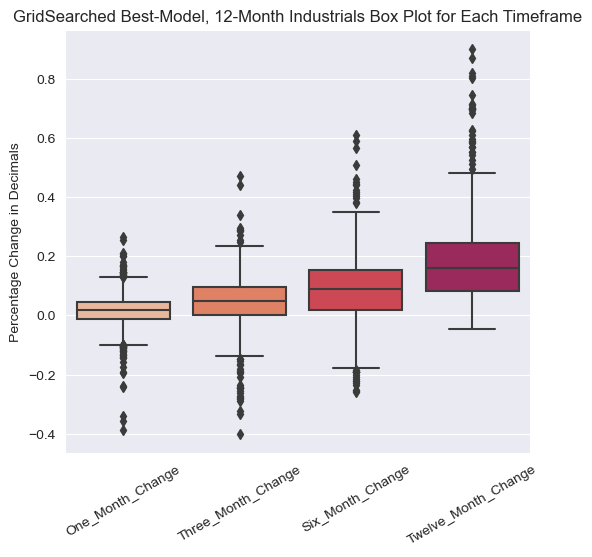

In [230]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Industrials[23], "XLI", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

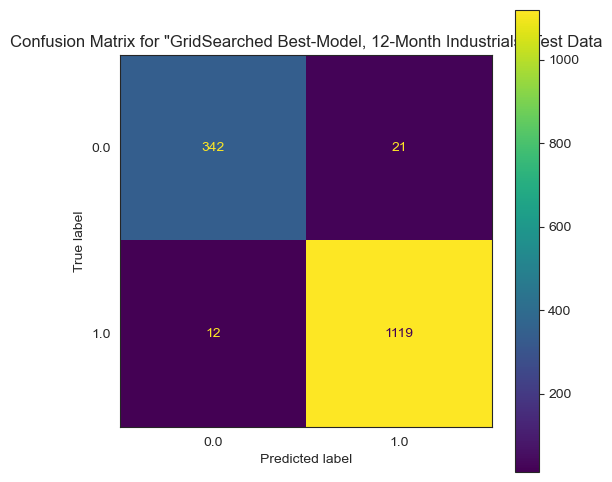

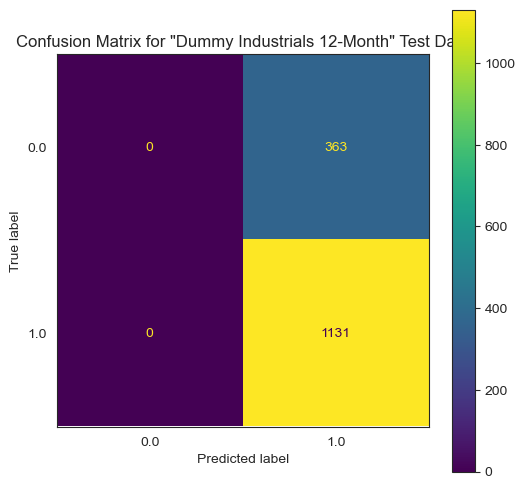

In [59]:
# Shows the best model's predictions and the dummy for that particular time horizon
Industrials[23].confusion_matrix(), Industrials[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [61]:
# Feature Importances for each time-horizon's best model
print_feature_importances(12, 16, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
lower_bollinger_band     0.055095
20_day_SMA               0.054760
MACD                     0.054006
lowest_bollinger_band    0.052768
upper_bollinger_band     0.052674
Name: Industrials 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates          0.062705
GDP                     0.050824
ATR                     0.046958
20_day_SMA              0.046369
upper_bollinger_band    0.046070
Name: Industrials 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                     0.082639
Interest Rates          0.070113
High                    0.046677
lower_bollinger_band    0.046364
Adj Close               0.045920
Name: Industrials 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                 0.078289
Interest Rates      0.075911
ATR                 0.050026
High   

<hr style="border: 4px solid black">

# Technology XLK

This is the first sector to have a 3-Month model perform the best. Other interesting observations are that GDP and Interest Rates have a significantly amplified importance on longer term returns. The importances: `Interest Rates 0.097131 GDP 0.096880 for 12-Month best model` are the highest relative importances individually and by a pair of factors so far in my analysis. Garman-Klass Volatility and ATR are close behind for the 12-month importance, and both of those factors measure volatility. 

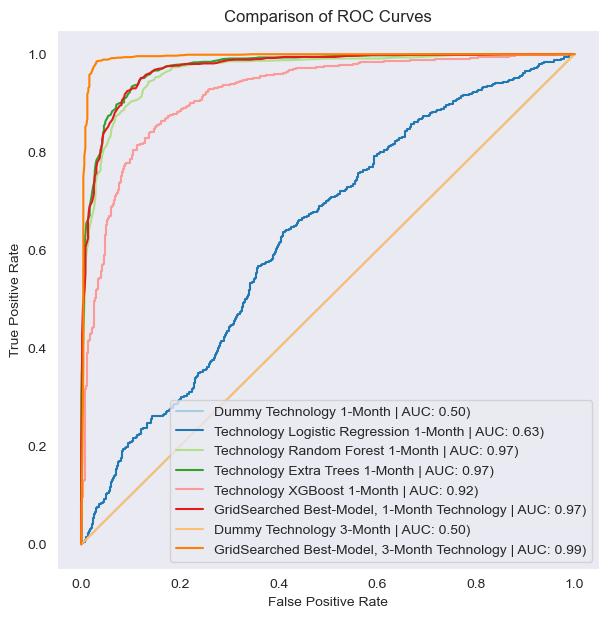

In [70]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Technology[0], Technology[1], Technology[2],Technology[3],Technology[4],Technology[5], \
                Technology[6], Technology[11]])

# 11 was the best model of this sector

### Best Models for the Sector

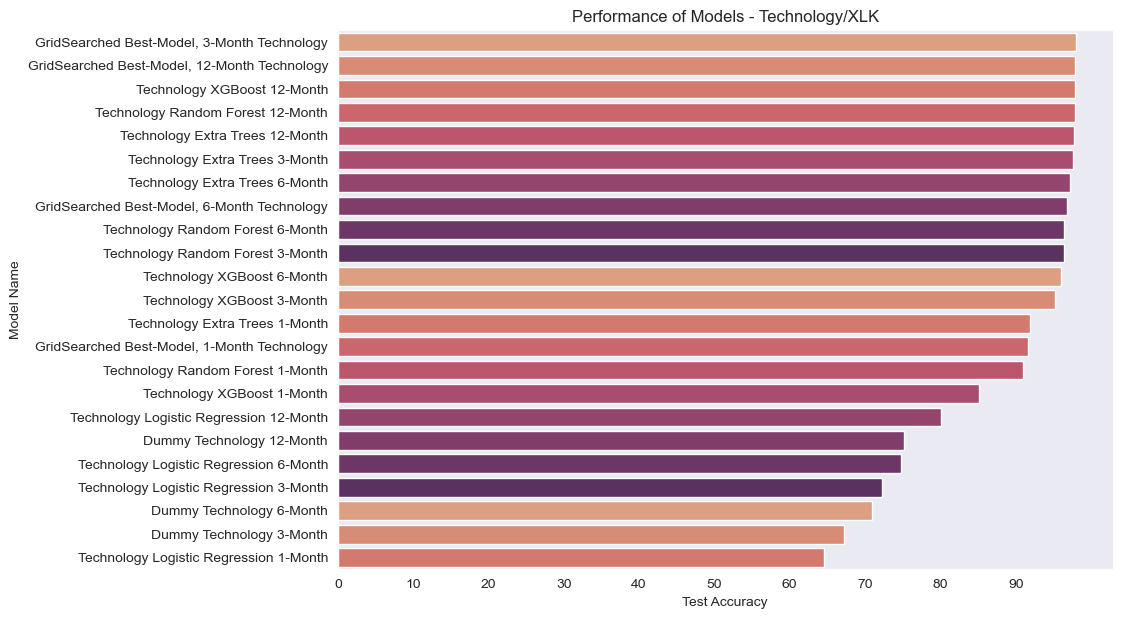

In [69]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Technology_df, "Technology/XLK", num_include=-1)

In [72]:
# These were the models with the highest accuracy score for this ETF

Technology_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
11,"GridSearched Best-Model, 3-Month Technology",0.954922,0.958811,0.974170,0.966398,0.140868,0.979920,0.984095,0.986056,0.985075,0.141874,0.993308
23,"GridSearched Best-Model, 12-Month Technology",0.983709,0.985611,0.992868,0.989209,0.083495,0.979250,0.978109,0.994657,0.986313,0.076691,0.996744
22,Technology XGBoost 12-Month,0.978576,0.982068,0.989599,0.985804,0.068821,0.978581,0.979771,0.991986,0.985841,0.067666,0.994199
20,Technology Random Forest 12-Month,0.981923,0.983312,0.992868,0.988045,0.079897,0.978581,0.977253,0.994657,0.985878,0.082451,0.996133
21,Technology Extra Trees 12-Month,0.984155,0.987893,0.991085,0.989477,0.072622,0.977912,0.978910,0.991986,0.985405,0.048016,0.998020


### How did our model perform when predicting "BUY"?
The best model was a 3-month model, based on the ExtraTreesClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Three_Month_Change" column, the `median return on predicted "buys" for 3-Months was 7.25%. The worst outcome on a predicted "buy" was a loss of 2.5%.` 

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1006.000000,1006.000000,1006.000000,1006.000000
mean,0.028506,0.085046,0.114531,0.179132
std,0.053744,0.064687,0.112985,0.205109
min,-0.211148,-0.024662,-0.349971,-0.479234
25%,-0.001675,0.038917,0.056962,0.079103
50%,0.027768,0.072499,0.108717,0.188816
75%,0.056234,0.112763,0.169220,0.297486
max,0.309667,0.416989,0.530661,0.809984


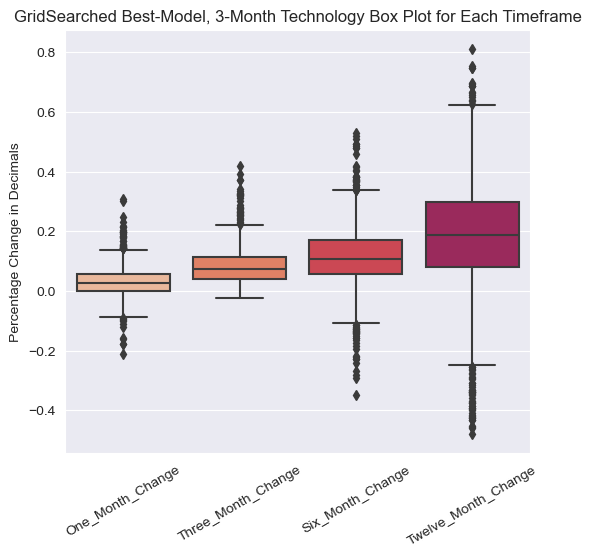

In [231]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Technology[11], "XLK", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

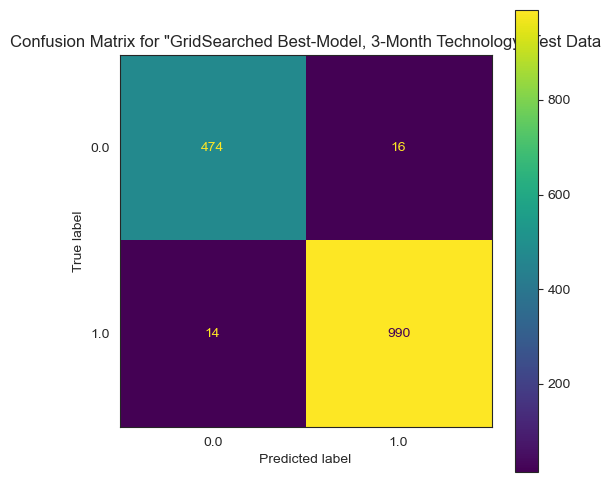

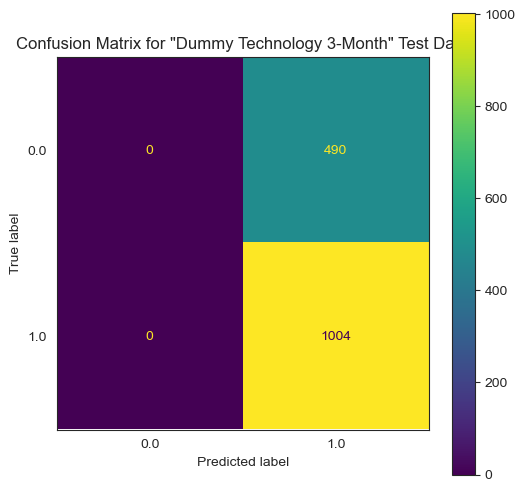

In [75]:
# Shows the best model's predictions and the dummy for that particular time horizon
Technology[11].confusion_matrix(), Technology[6].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [76]:
# Feature Importances for each time-horizon's best model
print_feature_importances(16, 20, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
Interest Rates           0.058166
ATR                      0.054648
20_day_SMA               0.051233
one_up_bollinger_band    0.050973
MACD                     0.050290
Name: Technology 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates           0.068614
GDP                      0.058952
ATR                      0.048948
upper_bollinger_band     0.048636
one_up_bollinger_band    0.046432
Name: Technology 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates          0.091383
GDP                     0.079836
ATR                     0.053703
upper_bollinger_band    0.047828
High                    0.046299
Name: Technology 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates      0.097131
GDP                 0.096880
garman_klass_vol    0.086815
ATR  

<hr style="border: 4px solid black">

# Staples XLP

We are back to longterm predictions being the most accurate. Interestingly, for 3-months Interest Rates are alone on top of the importance list, followed by technical indicators. The largest 12-Month gain for this sector is around 43% which is quite a small number compared to other sectors. This is an area to invest in if you want to experience relatively low volatility and reap steady dividends. 

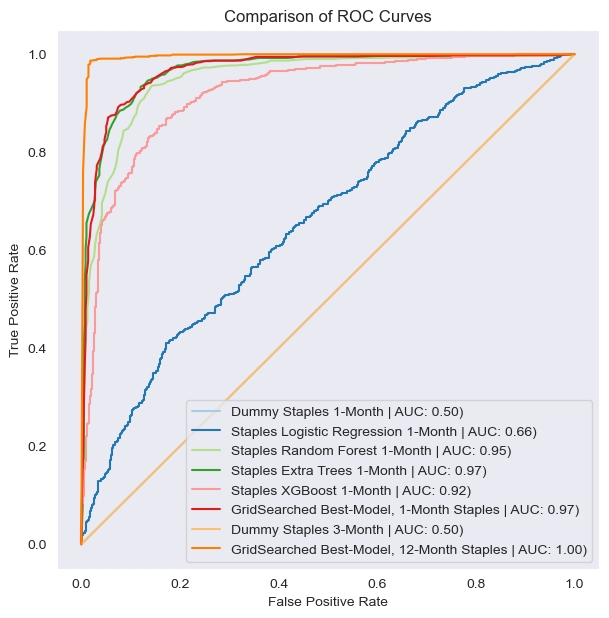

In [79]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Staples[0], Staples[1], Staples[2],Staples[3],Staples[4],Staples[5], \
                Staples[6], Staples[23]])

# 23 was the best model of this sector

### Best Models for the Sector

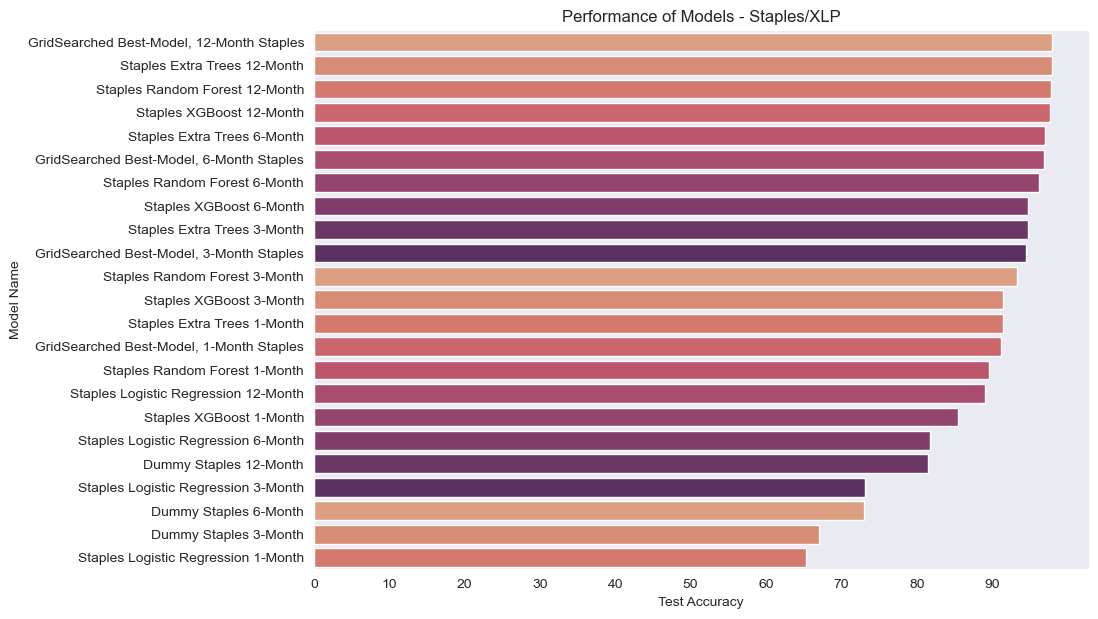

In [78]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Staples_df, "Staples/XLP", num_include=-1)

In [80]:
# These were the models with the highest accuracy score for this ETF

Staples_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Staples",0.977460,0.984837,0.987742,0.986271,0.060305,0.979250,0.983700,0.990969,0.987321,0.074018,0.995184
21,Staples Extra Trees 12-Month,0.977460,0.984837,0.987742,0.986271,0.060305,0.979250,0.983700,0.990969,0.987321,0.074018,0.995184
20,Staples Random Forest 12-Month,0.973219,0.982403,0.985017,0.983690,0.084325,0.977912,0.979757,0.993432,0.986547,0.086728,0.994302
22,Staples XGBoost 12-Month,0.972326,0.980063,0.986380,0.983186,0.095691,0.977242,0.980519,0.991790,0.986122,0.084994,0.995005
15,Staples Extra Trees 6-Month,0.956258,0.965498,0.975876,0.970619,0.151547,0.969880,0.972875,0.986251,0.979518,0.099960,0.993500


### How did our model perform when predicting "BUY"?
The best model was a 12-month model, based on the ExtraTreesClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 11.6%. The worst outcome on a predicted "buy" was a loss of 3.3%.` Fairly dull, and relatively unappealing upside potentital.

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1227.000000,1227.000000,1227.000000,1227.000000
mean,0.008981,0.026902,0.057955,0.117727
std,0.034649,0.053512,0.062147,0.070517
min,-0.219089,-0.221574,-0.138157,-0.032689
25%,-0.008828,-0.002861,0.016871,0.064125
50%,0.011061,0.032225,0.059572,0.116029
75%,0.028765,0.059734,0.097462,0.161353
max,0.190346,0.248114,0.293048,0.428770


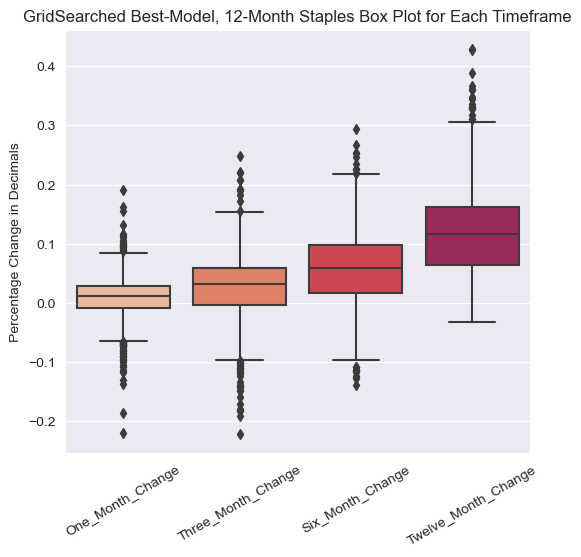

In [232]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Staples[23], "XLP", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

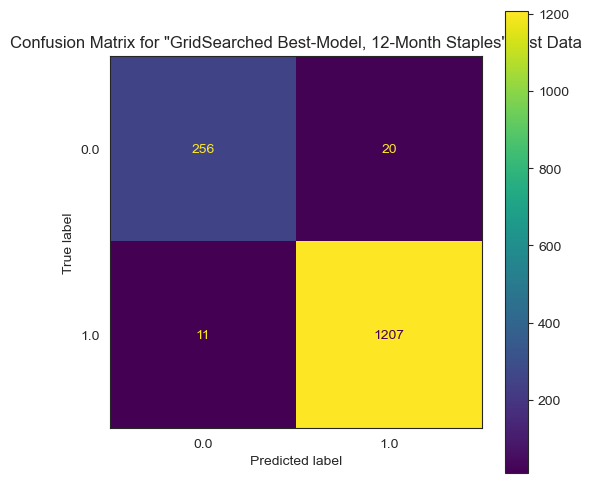

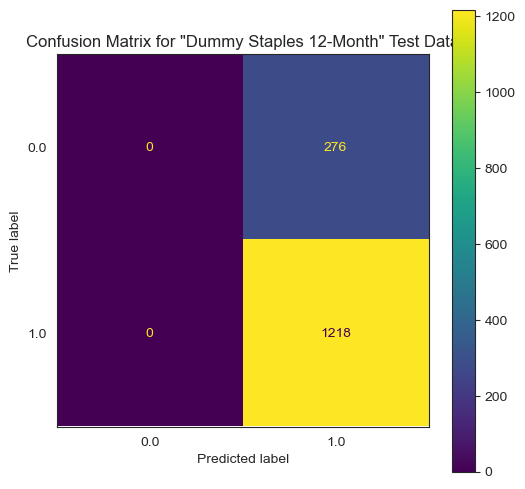

In [117]:
# Shows the best model's predictions and the dummy for that particular time horizon
Staples[23].confusion_matrix(), Staples[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [118]:
# Feature Importances for each time-horizon's best model
print_feature_importances(20, 24, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
lower_bollinger_band     0.057661
one_up_bollinger_band    0.056470
20_day_SMA               0.056249
upper_bollinger_band     0.055725
lowest_bollinger_band    0.053198
Name: Staples 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates          0.061195
High                    0.047908
upper_bollinger_band    0.047545
Low                     0.046776
ATR                     0.046289
Name: Staples 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                      0.067911
Interest Rates           0.067144
one_up_bollinger_band    0.049174
garman_klass_vol         0.048983
upper_bollinger_band     0.047626
Name: Staples 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates      0.079822
GDP                 0.078687
garman_klass_vol    0.071106
High          

<hr style="border: 4px solid black">

# Utilities XLU

The largest 12-month gain was around 43.7%, so quite similar to the Staples Sector. Twelve month importances of: GDP 0.096483 Interest Rates 0.090359 garman_klass_vol 0.085090 represent the largest trio of importances so far. The largest 12-Month gain for this sector is around 43% which is quite a small number compared to other sectors. This is another area to invest in if you want to experience relatively low volatility and reap steady dividends. 

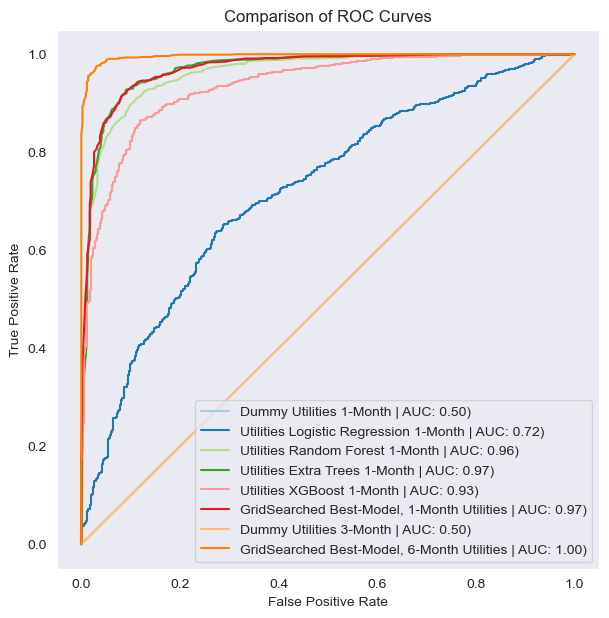

In [121]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Utilities[0], Utilities[1], Utilities[2],Utilities[3],Utilities[4],Utilities[5], \
                Utilities[6], Utilities[17]])

# 17 was the best model of this sector

### Best Models for the Sector

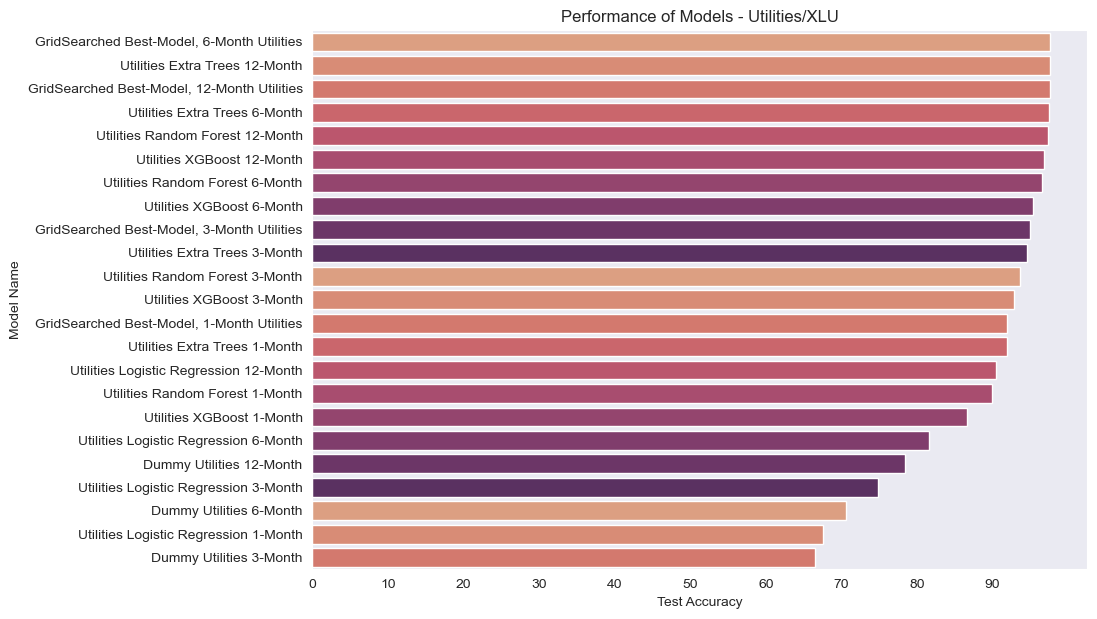

In [120]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Utilities_df, "Utilities/XLU", num_include=-1)

In [122]:
# These were the models with the highest accuracy score for this ETF

Utilities_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
17,"GridSearched Best-Model, 6-Month Utilities",0.966302,0.976146,0.976441,0.976274,0.117217,0.976573,0.979323,0.987678,0.983483,0.082363,0.996719
21,Utilities Extra Trees 12-Month,0.975676,0.981942,0.986696,0.984281,0.067812,0.976573,0.983830,0.986348,0.985087,0.074834,0.996105
23,"GridSearched Best-Model, 12-Month Utilities",0.976345,0.983620,0.985829,0.984698,0.069450,0.975904,0.982173,0.987201,0.984681,0.077209,0.995983
15,Utilities Extra Trees 6-Month,0.966079,0.976142,0.976127,0.976121,0.123483,0.975234,0.982008,0.982938,0.982473,0.081693,0.996557
20,Utilities Random Forest 12-Month,0.970319,0.977707,0.984093,0.980842,0.085620,0.973226,0.980475,0.985495,0.982979,0.069173,0.996235


### How did our model perform when predicting "BUY"?
The best model was a 6-month model, based on the ExtraTreesClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Six_Month_Change" column, the `median return on predicted "buys" for 6-Months was 8.5%. The worst outcome on a predicted "buy" was a loss of 4.1%.`

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1064.000000,1064.000000,1064.000000,1064.000000
mean,0.016576,0.046262,0.093788,0.149787
std,0.039077,0.055319,0.059442,0.099861
min,-0.202216,-0.117051,-0.041012,-0.273033
25%,-0.006338,0.010366,0.048732,0.090648
50%,0.016587,0.047160,0.085360,0.148655
75%,0.040657,0.078163,0.132851,0.207184
max,0.154811,0.264210,0.284875,0.437271


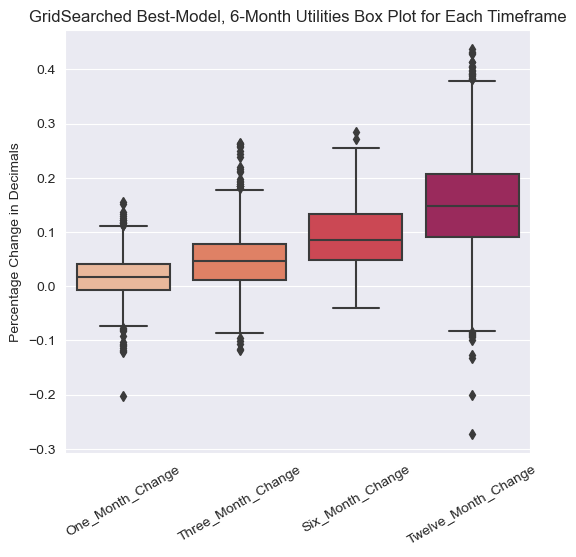

In [233]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Utilities[17], "XLU", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

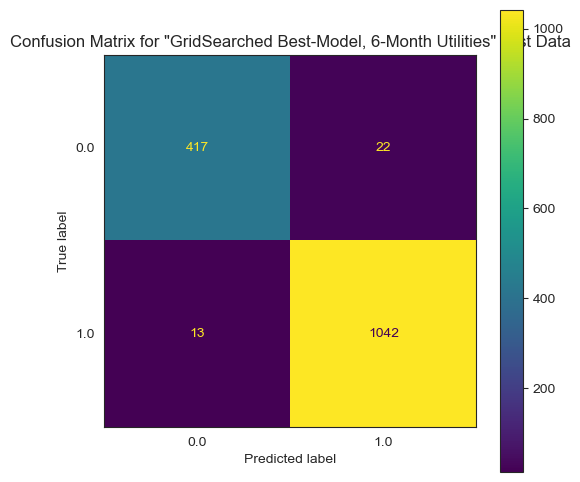

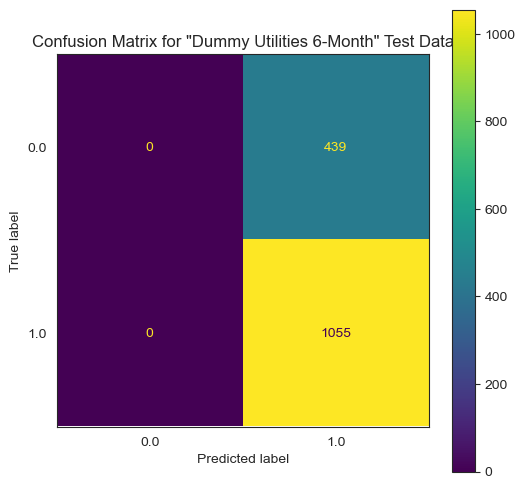

In [125]:
# Shows the best model's predictions and the dummy for that particular time horizon
Utilities[17].confusion_matrix(), Utilities[12].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [126]:
# Feature Importances for each time-horizon's best model
print_feature_importances(24, 28, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
lower_bollinger_band     0.056043
20_day_SMA               0.055570
one_up_bollinger_band    0.054480
lowest_bollinger_band    0.053905
upper_bollinger_band     0.052809
Name: Utilities 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                     0.054704
Interest Rates          0.053367
20_day_SMA              0.047401
lower_bollinger_band    0.047389
Close                   0.047001
Name: Utilities 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                 0.068922
Interest Rates      0.058678
garman_klass_vol    0.055676
Low                 0.049335
Close               0.048516
Name: Utilities 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                      0.096483
Interest Rates           0.090359
garman_klass_vol         0.085090
Close             

<hr style="border: 4px solid black">

# Health Care XLV

Feature importance of .113 for Interest Rates over 12-Month predictions is the new high value.  
Median 12-Month returns on positive predictions were 11.3%, with the worst outcome being a 3.9% loss. The best model was 96.7% accurate on unseen data. Maximum 12-Month gains were 47%, and this is a comparitively low total gain compared to other sectors. 

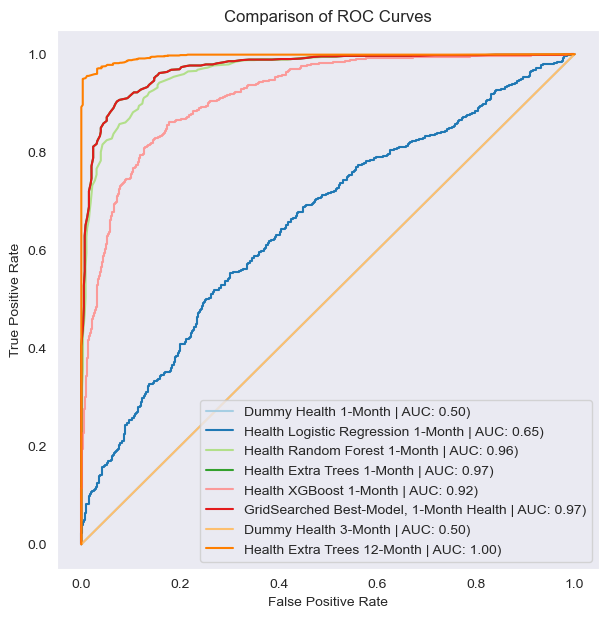

In [137]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Health[0], Health[1], Health[2],Health[3],Health[4],Health[5], \
                Health[6], Health[21]])

# 21 was the best model of this sector

### Best Models for the Sector

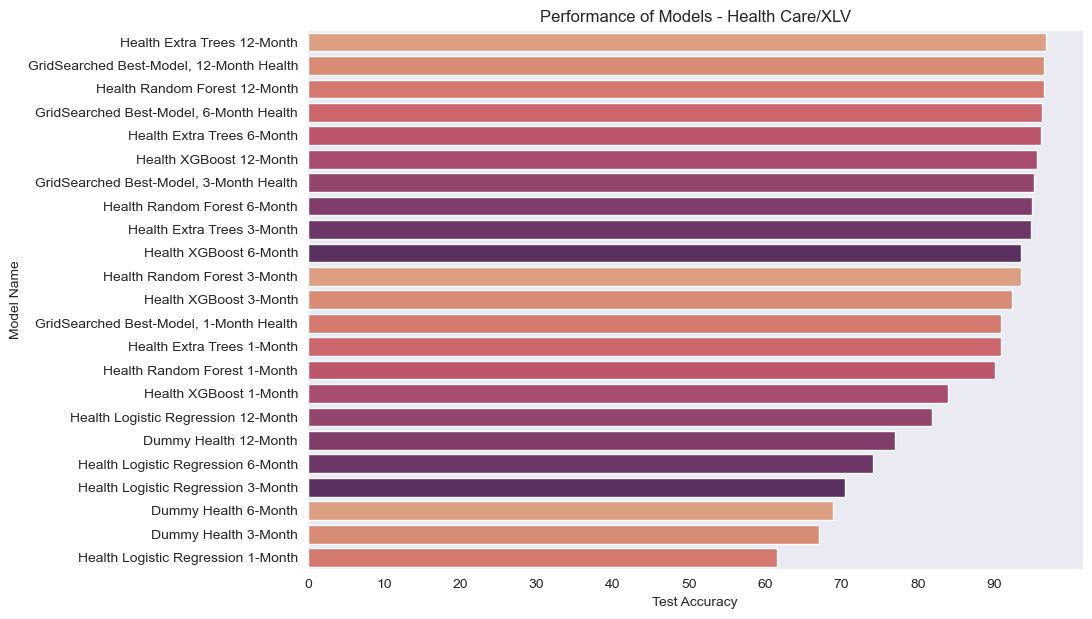

In [135]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Health_df, "Health Care/XLV", num_include=-1)

In [136]:
# These were the models with the highest accuracy score for this ETF

Health_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Health Extra Trees 12-Month,0.966079,0.976055,0.979971,0.977980,0.106765,0.967871,0.975841,0.982624,0.979221,0.097262,0.995833
23,"GridSearched Best-Model, 12-Month Health",0.967642,0.976651,0.981422,0.979003,0.108773,0.965863,0.973322,0.982624,0.977951,0.079737,0.995788
20,Health Random Forest 12-Month,0.956706,0.968617,0.975327,0.971933,0.125550,0.965194,0.971674,0.983493,0.977547,0.097942,0.994395
17,"GridSearched Best-Model, 6-Month Health",0.946665,0.961721,0.960730,0.961185,0.142406,0.963186,0.971872,0.974708,0.973288,0.126128,0.992967
15,Health Extra Trees 6-Month,0.945549,0.960759,0.960080,0.960375,0.145458,0.961847,0.970902,0.973735,0.972317,0.127297,0.993182


### How did our model perform when predicting "BUY"?
The best model was a 12-month ExtraTreesClassifier. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 11%. The worst outcome on a predicted "buy" was a loss of 3.8%.`

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1159.000000,1159.000000,1159.000000,1159.000000
mean,0.012198,0.036978,0.071127,0.137052
std,0.043865,0.060843,0.075709,0.099118
min,-0.234885,-0.268059,-0.161913,-0.038881
25%,-0.011474,0.001026,0.017562,0.060313
50%,0.015769,0.041859,0.078110,0.111383
75%,0.036695,0.078825,0.120693,0.216482
max,0.247299,0.230869,0.367059,0.474715


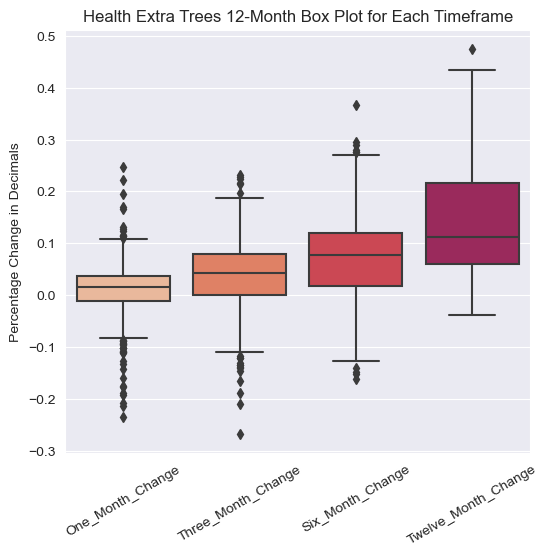

In [234]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Health[21], "XLV", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

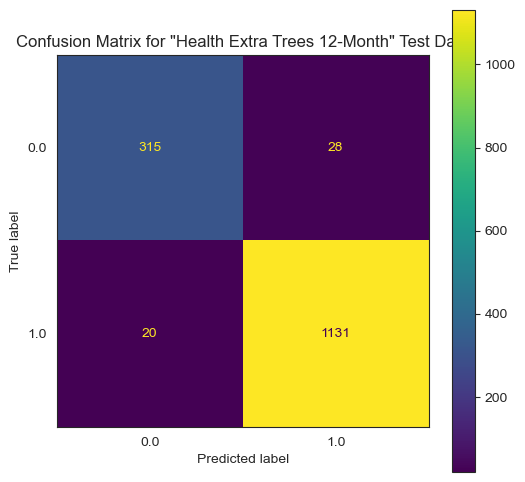

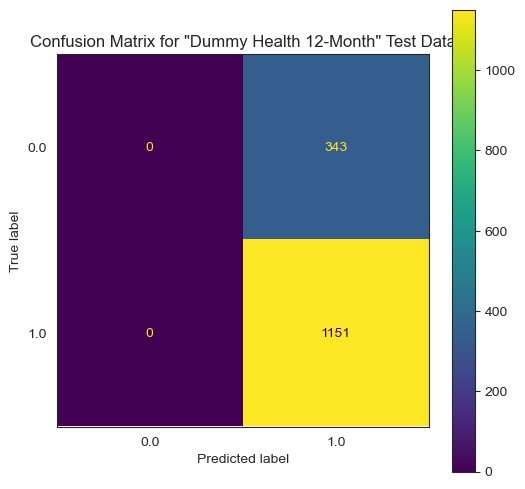

In [140]:
# Shows the best model's predictions and the dummy for that particular time horizon
Health[21].confusion_matrix(), Health[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [141]:
# Feature Importances for each time-horizon's best model
print_feature_importances(28, 32, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
Interest Rates           0.056406
20_day_SMA               0.055174
one_up_bollinger_band    0.053068
lower_bollinger_band     0.051083
MACD                     0.050518
Name: Health Care 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates           0.053018
one_up_bollinger_band    0.051063
GDP                      0.050574
20_day_SMA               0.049342
upper_bollinger_band     0.048677
Name: Health Care 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates          0.060711
GDP                     0.058759
Close                   0.051758
upper_bollinger_band    0.050995
High                    0.049007
Name: Health Care 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates          0.113440
GDP                     0.064047
upper_bollinger_band   

<hr style="border: 4px solid black">

# Consumer Discretionary XLY

Feature importance of .125 for Interest Rates over 12-Month predictions is `AGAIN a new high value.` Interest Rates were also the most important feature for every time horizon. This makes perfect logical sense, as when interest rates are lower, the costs of borrowing are lower,thereby incentivizing more consumer expenditures. Median 12-Month returns on positive predictions were 17.3%, with the worst outcome being a 2.3% loss. The best model was 98% accurate on unseen data. Maximum 12-Month gains were 90%, making this model's predictions amongst the best performing so far.

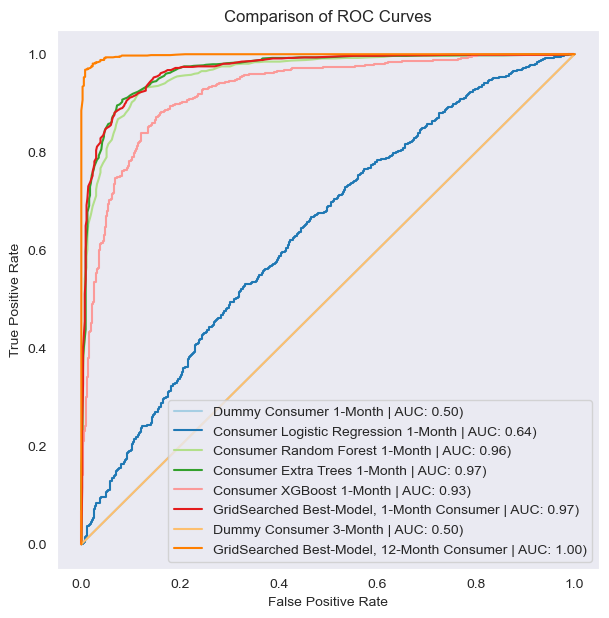

In [151]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Consumer_Disc[0], Consumer_Disc[1], Consumer_Disc[2],Consumer_Disc[3],Consumer_Disc[4],Consumer_Disc[5], \
                Consumer_Disc[6], Consumer_Disc[23]])

# 23 was the best model of this sector

### Best Models for the Sector

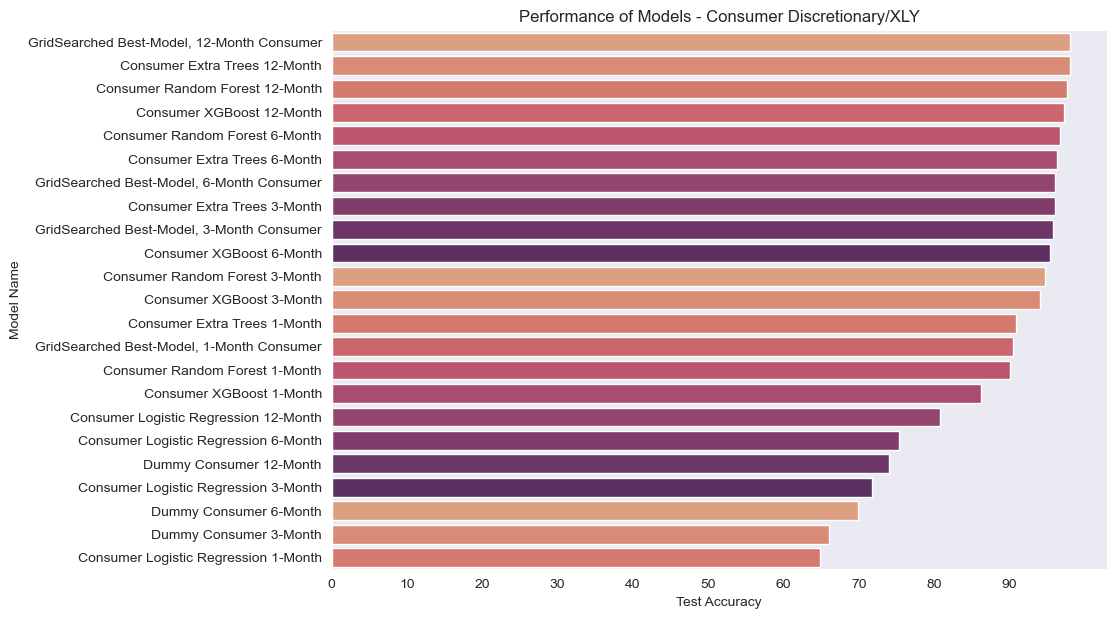

In [152]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Consumer_Disc_df, "Consumer Discretionary/XLY", num_include=-1)

In [153]:
# These were the models with the highest accuracy score for this ETF

Consumer_Disc_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Consumer",0.978798,0.983760,0.988119,0.985922,0.077276,0.979920,0.986425,0.986425,0.986425,0.053652,0.998187
21,Consumer Extra Trees 12-Month,0.978798,0.983760,0.988119,0.985922,0.077276,0.979920,0.986425,0.986425,0.986425,0.053652,0.998187
20,Consumer Random Forest 12-Month,0.973667,0.978559,0.986635,0.982556,0.104951,0.975904,0.982836,0.984615,0.983725,0.076566,0.996128
22,Consumer XGBoost 12-Month,0.973220,0.978236,0.986336,0.982249,0.088385,0.971888,0.980995,0.980995,0.980995,0.081032,0.995545
14,Consumer Random Forest 6-Month,0.952688,0.963048,0.968608,0.965800,0.158728,0.967202,0.976989,0.976054,0.976521,0.126623,0.990143


### How did our model perform when predicting "BUY"?
The best model was a 12-month GridSearch tuned ExtraTreesClassifier. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 17.3%. The worst outcome on a predicted "buy" was a loss of 2.3%.` This is a very attractive risk-reward profile.

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1105.000000,1105.000000,1105.000000,1105.000000
mean,0.015195,0.046792,0.094293,0.191492
std,0.057669,0.085443,0.108570,0.133145
min,-0.336382,-0.292172,-0.238092,-0.023077
25%,-0.013502,0.003055,0.025242,0.098437
50%,0.018366,0.045144,0.088567,0.172968
75%,0.044969,0.092212,0.155422,0.258944
max,0.288779,0.448024,0.632949,0.899413


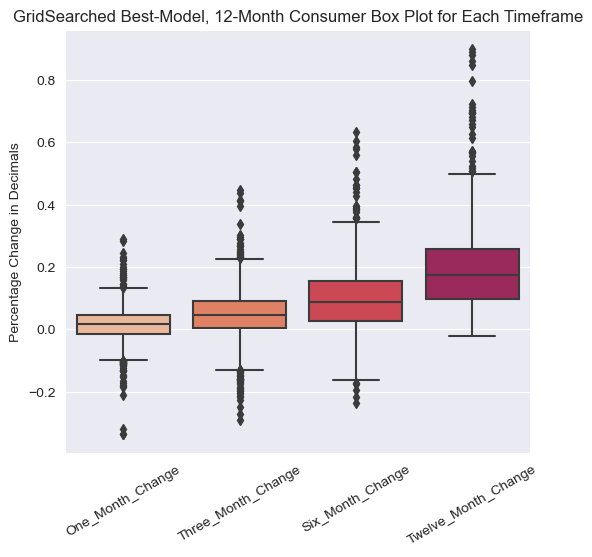

In [235]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Consumer_Disc[23], "XLY", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

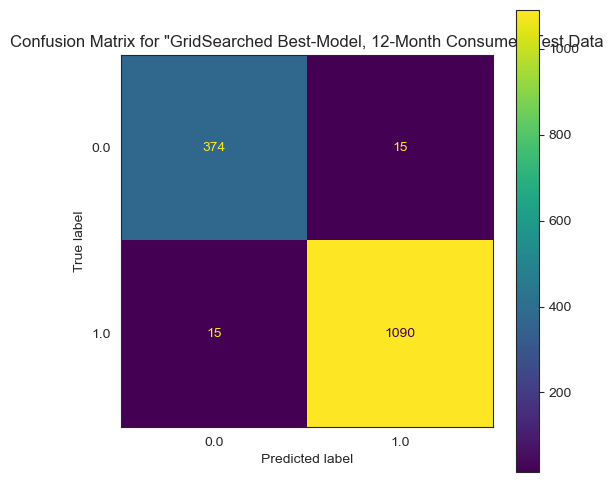

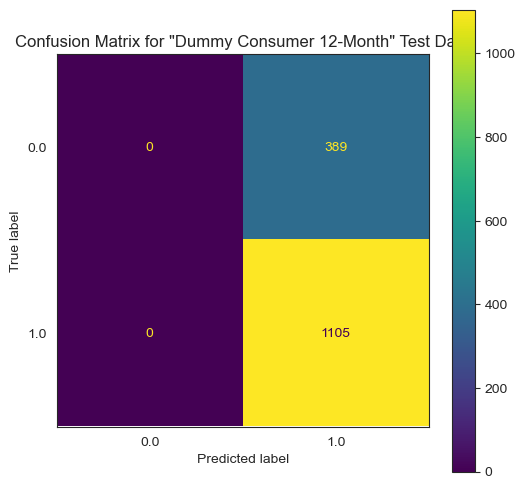

In [149]:
# Shows the best model's predictions and the dummy for that particular time horizon
Consumer_Disc[23].confusion_matrix(), Consumer_Disc[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [150]:
# Feature Importances for each time-horizon's best model
print_feature_importances(32, 36, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
Interest Rates           0.059273
MACD                     0.054148
one_up_bollinger_band    0.053926
20_day_SMA               0.052313
lower_bollinger_band     0.051513
Name: Consumer Discretionary 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates          0.074495
ATR                     0.049551
High                    0.047655
20_day_SMA              0.046885
lower_bollinger_band    0.046711
Name: Consumer Discretionary 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates           0.121520
GDP                      0.077943
ATR                      0.068411
one_up_bollinger_band    0.060726
upper_bollinger_band     0.058176
Name: Consumer Discretionary 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates           0.125463
GDP                   

<hr style="border: 4px solid black">

# Real Estate XLRE

The Real Estate SPDR has only existed since October of 2015, so there is admitedly less data to parse for this sector. All feature importances for different timeframes were relatively subdued, with no individual value above 0.071. Real Estate is considered to be another low volatility sector that pays dividends regularly. There have been exogenous shocks to this sector in the wake of Covid however, and the prevalence of "Work From Home" policies. With hybrid work becoming at least part of the new work pardigm, the future of commercial real estate is somewhat hazy. The largest 12 Month gain on positive predictions was rouhgly 49% generally in line with other sectors' models.  

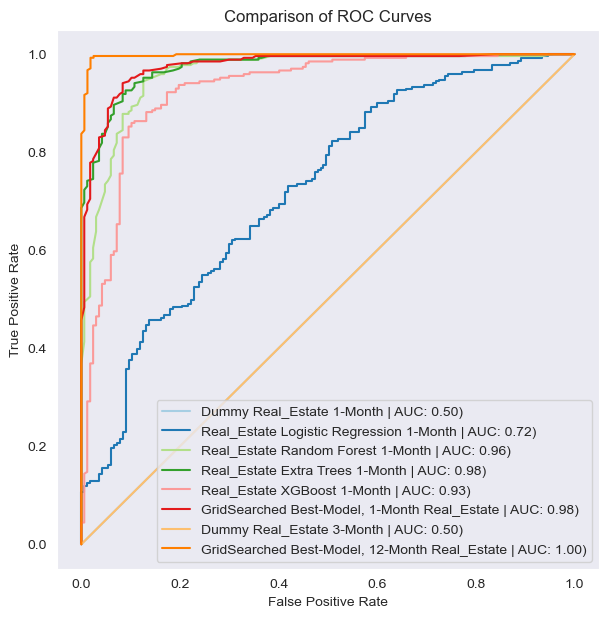

In [155]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Real_Estate[0], Real_Estate[1], Real_Estate[2],Real_Estate[3],Real_Estate[4],Real_Estate[5], \
                Real_Estate[6], Real_Estate[23]])

# 23 was the best model of this sector

### Best Models for the Sector

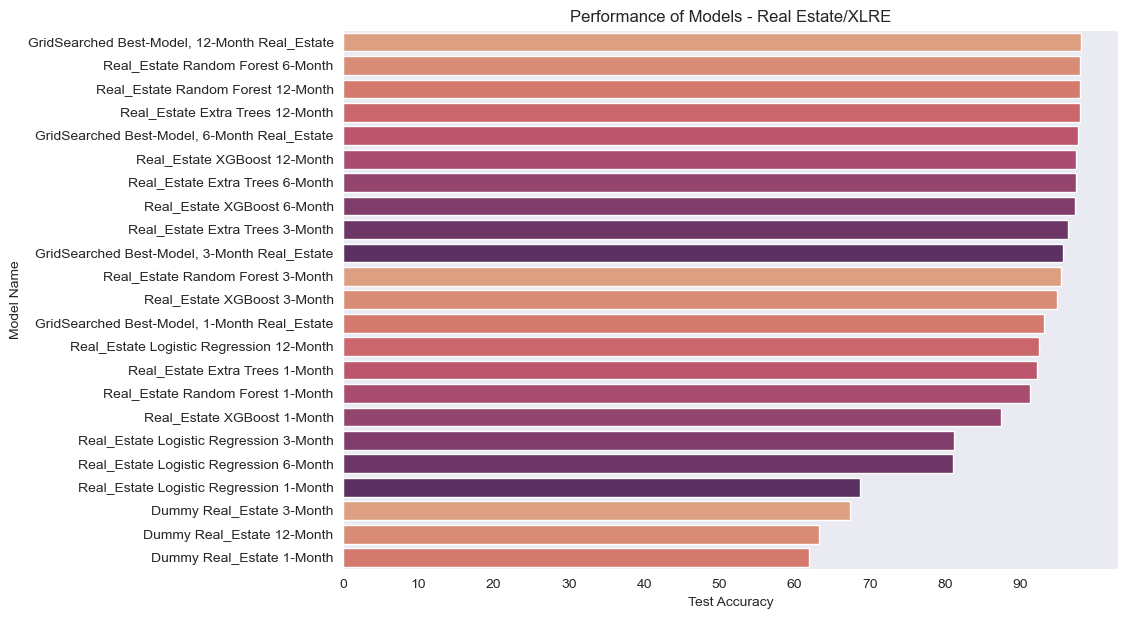

In [156]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Real_Estate_df, "Real Estate/XLRE", num_include=-1)

In [164]:
# These were the models with the highest accuracy score for this ETF

Real_Estate_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Real_Estate",0.957293,0.970728,0.961212,0.965901,0.145373,0.981735,0.989091,0.981949,0.985507,0.076145,0.997679
14,Real_Estate Random Forest 6-Month,0.967225,0.980101,0.969591,0.974722,0.105576,0.979452,0.992481,0.974170,0.983240,0.083799,0.995658
20,Real_Estate Random Forest 12-Month,0.949685,0.959993,0.960000,0.959958,0.160502,0.979452,0.978571,0.989170,0.983842,0.086855,0.996143
21,Real_Estate Extra Trees 12-Month,0.953490,0.964801,0.961212,0.962980,0.169770,0.979452,0.989051,0.978339,0.983666,0.075740,0.997623
17,"GridSearched Best-Model, 6-Month Real_Estate",0.969509,0.981221,0.971930,0.976497,0.106373,0.977169,0.992453,0.970480,0.981343,0.165207,0.994023


### How did our model perform when predicting "BUY"?
The best model was a 12-month GridSearch tuned ExtraTreesClassifier. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 17.2%. The worst outcome on a predicted "buy" was a loss of 0.5%.` This potential loss amount is the lowest of any sector thus far. 

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,275.000000,275.000000,275.000000,275.000000
mean,0.018182,0.046613,0.083328,0.165291
std,0.043474,0.063213,0.090782,0.124625
min,-0.123133,-0.108449,-0.092140,-0.005758
25%,-0.009845,0.008818,0.023310,0.049233
50%,0.014250,0.042856,0.076401,0.172290
75%,0.044589,0.080202,0.136540,0.258353
max,0.166359,0.237474,0.331196,0.489923


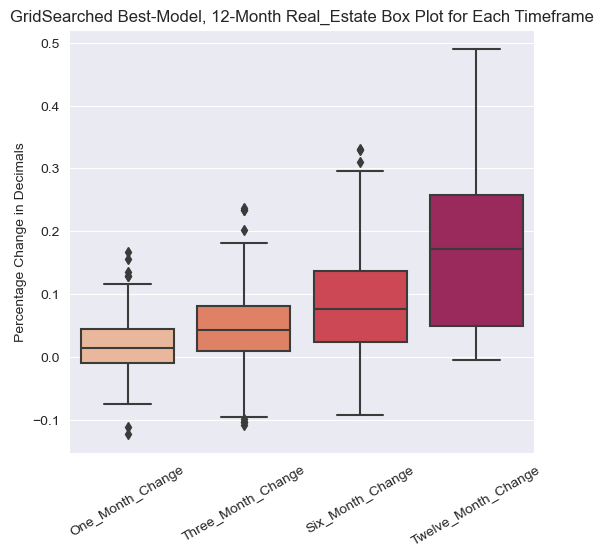

In [236]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Real_Estate[23], "XLRE", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

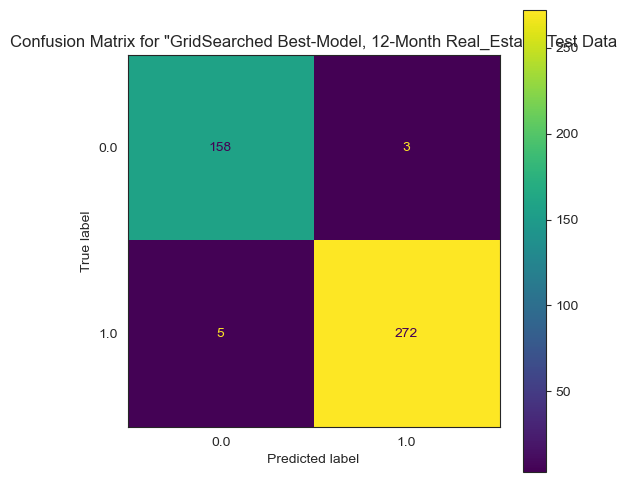

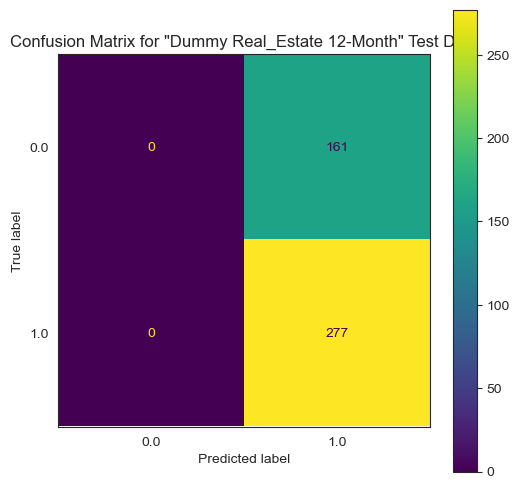

In [159]:
# Shows the best model's predictions and the dummy for that particular time horizon
Real_Estate[23].confusion_matrix(), Real_Estate[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [160]:
# Feature Importances for each time-horizon's best model
print_feature_importances(36, 40, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
20_day_SMA               0.057025
lower_bollinger_band     0.056184
upper_bollinger_band     0.055544
lowest_bollinger_band    0.054696
one_up_bollinger_band    0.054174
Name: Real Estate 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest Rates          0.063667
GDP                     0.056913
Low                     0.049798
upper_bollinger_band    0.047947
Adj Close               0.045653
Name: Real Estate 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
Low                      0.071459
Close                    0.069580
lowest_bollinger_band    0.064575
Open                     0.060887
one_up_bollinger_band    0.059973
Name: Real Estate 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
lowest_bollinger_band    0.067436
High                     0.066827
Interest Rates       

<hr style="border: 4px solid black">

# Communication Service XLC

The XLC has only existed since 2018, so once again we suffer from a lack of data, and perhaps our analysis of these results should be tempered by that fact.  The median return on predicted "buys" for 12-Months was quite high at 23.2%. The worst outcome on a predicted "buy" was a loss of 2.8%, which was surprisingly low. However, our X_train data only goes through October of 2022, which was very near to a market top. Three-month importances of:GDP 0.332039 and cycle_year_3 0.250401 are the most important values thus far, and I would have to attribute that to the lack of data more than being a true signal. 

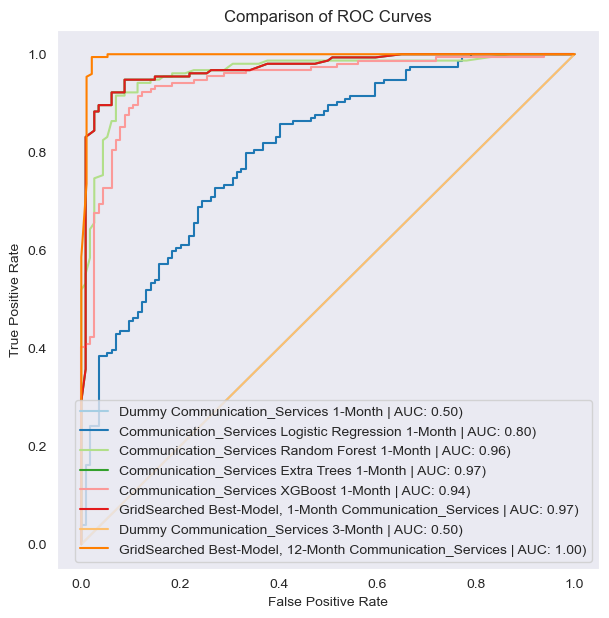

In [166]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Comms[0], Comms[1], Comms[2],Comms[3],Comms[4],Comms[5], \
                Comms[6], Comms[23]])

# 23 was the best model of this sector

### Best Models for the Sector

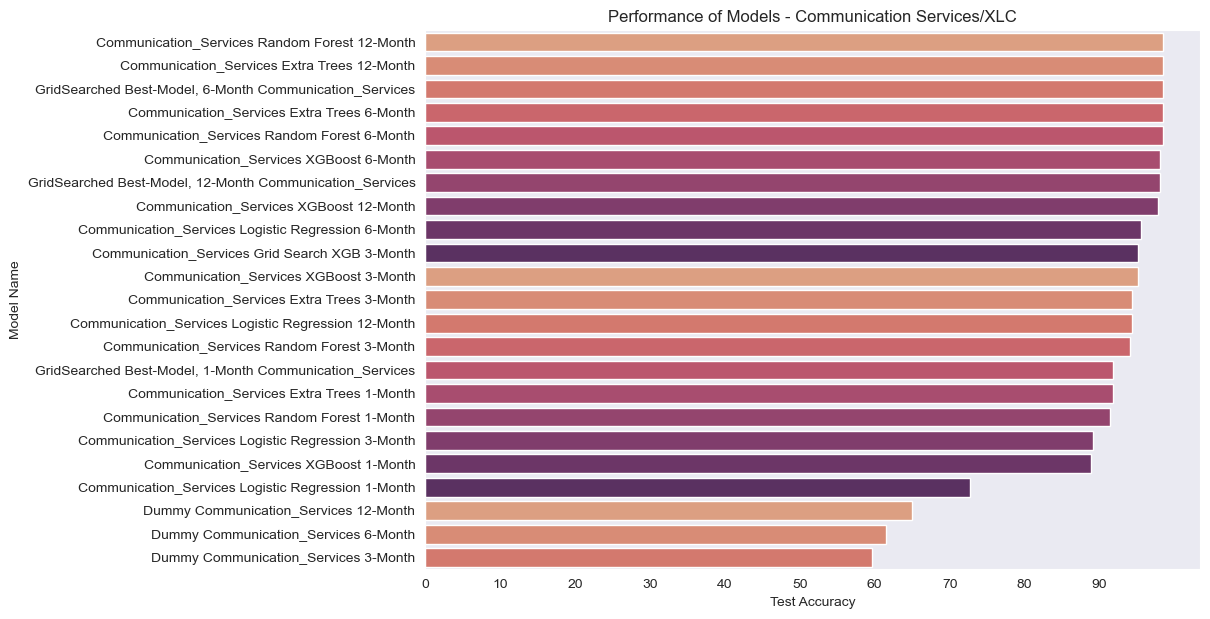

In [167]:
# Plotting the Test Accuracy of every model for this ETF

plot_test_accuracy(Comms_df, "Communication Services/XLC", num_include=-1)

In [168]:
# These were the models with the highest accuracy score for this ETF

Comms_df.sort_values(by='test_accuracy', ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
20,Communication_Services Random Forest 12-Month,0.977609,0.976476,0.990826,0.983553,0.063403,0.985075,0.977528,1.000000,0.988636,0.060206,0.997402
21,Communication_Services Extra Trees 12-Month,0.982578,0.983815,0.990826,0.987154,0.092066,0.985075,0.982955,0.994253,0.988571,0.049172,0.998961
17,"GridSearched Best-Model, 6-Month Communication...",0.978882,0.981666,0.983505,0.982520,0.130085,0.985075,1.000000,0.975758,0.987730,0.055740,0.997823
15,Communication_Services Extra Trees 6-Month,0.976390,0.977591,0.983505,0.980512,0.118715,0.985075,1.000000,0.975758,0.987730,0.047281,0.998970
14,Communication_Services Random Forest 6-Month,0.977640,0.979646,0.983505,0.981505,0.094233,0.985075,1.000000,0.975758,0.987730,0.062765,0.997499


### How did our model perform when predicting "BUY"?
The best model was a 12-month `RandomForestClassifier`, and this was the first occassion an RFC took the top spot. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 23.2%. The worst outcome on a predicted "buy" was a loss of 2.8%.` This median gain is higher than other sectors.

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,178.000000,178.000000,178.000000,178.000000
mean,-0.001481,0.036688,0.104958,0.251523
std,0.073345,0.105752,0.133953,0.166232
min,-0.294262,-0.191909,-0.228781,-0.028379
25%,-0.036751,-0.042811,0.013604,0.139599
50%,0.009914,0.056171,0.112339,0.232448
75%,0.044594,0.115076,0.220863,0.356870
max,0.196050,0.387843,0.450366,0.906922


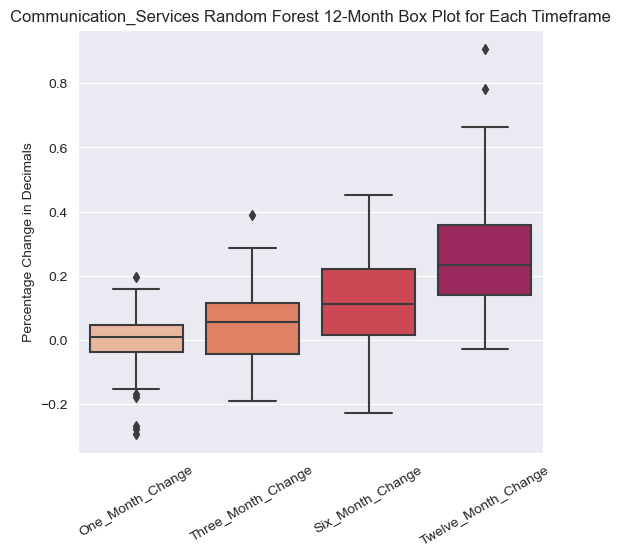

In [237]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Comms[20], "XLC", cat=1, box=True)

### Comparison of Dummy Confusion Matrix to the Best Model

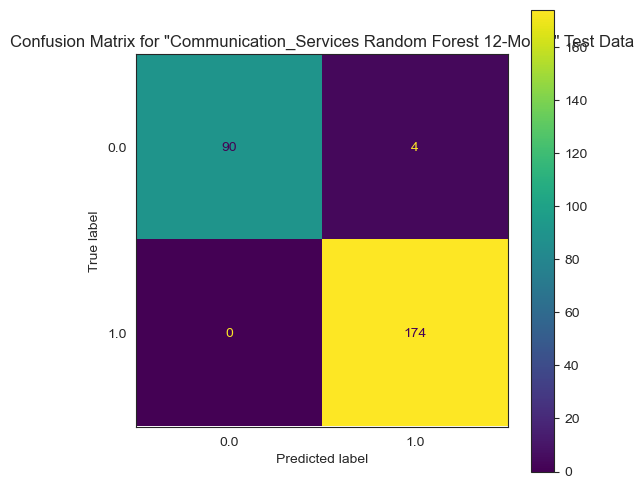

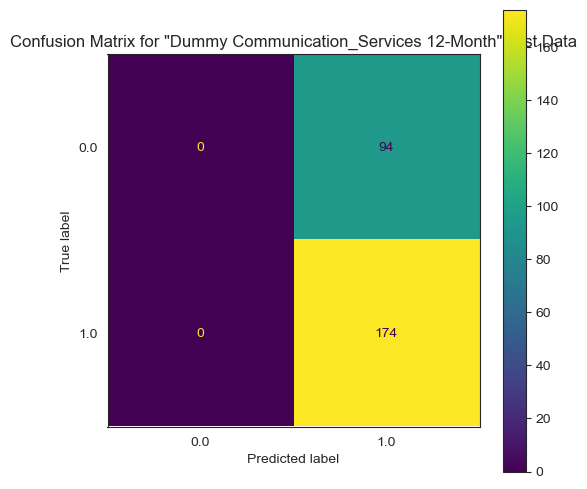

In [176]:
# Shows the best model's predictions and the dummy for that particular time horizon
Comms[20].confusion_matrix(), Comms[18].confusion_matrix();

### Feature Importances
 Feature Importances for each time-horizon's best model. These are not coefficients, but relative values of all features' importance, summing to 1.

In [174]:
# Feature Importances for each time-horizon's best model
print_feature_importances(40, 44, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
cycle_year_2            0.081180
GDP                     0.056375
Interest Rates          0.054709
MACD                    0.054274
lower_bollinger_band    0.046674
Name: Communication Services 1-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                      0.332039
cycle_year_3             0.250401
Open                     0.198960
lowest_bollinger_band    0.052592
ATR                      0.038934
Name: Communication Services 3-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP                      0.116671
upper_bollinger_band     0.081155
cycle_year_2             0.080549
one_up_bollinger_band    0.070177
Interest Rates           0.061487
Name: Communication Services 6-Month, dtype: float64
****************************************
Top 5 Feature Importance(s):
upper_bollinger_band     0.157036
one_up_bollinger_band 

<hr style="border: 6px solid red">

# Conclusions

The major trends in the analysis are that on longer time horizons, macro-economic factors have a greater influence on predictions, whereas technical indicators have a greater impact on short-term predictions. The top 5 models for each time horizon are accurate with ranges of: 
- 1-Month | 93-92%
- 3-Month | 98-96%
- 6-Month | 98.5 - 98%
- 12-Month | 98.5 - 98.2%
Predictions become fractionally more accurate as time horizons get larger. The best models profiles for each of those time horizons are:

# 1-Month Best Model Profile

In [181]:
describe_predictions(Real_Estate[5], "XLRE")[["One_Month_Change"]]

,One_Month_Change
count,275.000000
mean,0.038759
std,0.033402
min,-0.034037
25%,0.013083
50%,0.033268
75%,0.057261
max,0.166359


# 3-Month Best Model Profile

In [189]:
describe_predictions(Technology[11], "XLK")[["Three_Month_Change"]]

,Three_Month_Change
count,1006.000000
mean,0.085046
std,0.064687
min,-0.024662
25%,0.038917
50%,0.072499
75%,0.112763
max,0.416989


# 6-Month Best Model Profile

In [185]:
describe_predictions(Comms[17], "XLC")[["Six_Month_Change"]]

,Six_Month_Change
count,161.000000
mean,0.150368
std,0.089444
min,0.012526
25%,0.071711
50%,0.143934
75%,0.224480
max,0.450366


# 12-Month Best Model Profile

In [187]:
describe_predictions(Materials[-1], "XLB")[["Twelve_Month_Change"]]

,Twelve_Month_Change
count,1064.000000
mean,0.184612
std,0.131313
min,-0.057450
25%,0.099510
50%,0.159914
75%,0.240284
max,0.925471


### Recommendation
Based only on these models, the 6-month Communication Services predictions have a very appealing profile, as none of the positive predictions produced losses. The worst return was 1.25%. The median performance was also very close to inline with the median performance of our best 12-Month model, meaning that you could theoretically expect equivalent gains in half of the time. The main limitation is that the XLC (Comms) lacks sufficient data to be extremely confident in the validity of our model. Overall, every model performed extremely well. The type of model most frequently employed was the ExtraTreesClassifier. 

I think that it also is worth mentioning the box plots demonstrate how every targeted model's timeframe has an extremely low rate of negative returns. Futhermore, the outlier negative returns in those situations are extremely rare. Tech's best model was for 3-month predictions and Utilites for 6-month predictions, and neither of them exhibited any negative outliers. I would say that these models are very adept at minimizing outsized negative outcomes.

### Next Steps:
The next steps would be to, of course, continue to update the data with more observations. It would also be beneficial to add more features, such as the price of various commodities, oil most of all. There is still the potential to add many additional technical indicators as well, and all of these factors could conceivably improve the performance of the models, even though they have already achieved remarkable accuracy. Thank you very much for considering the data in this notebook. 